##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-Hub によるベンガル語の記事分類

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/hub/tutorials/bangla_article_classifier"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a>   </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub で表示</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/hub/tutorials/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a>   </td>
</table>

注意: このノートブックでは、pip を用いた Python パッケージのインストールに加え、`sudo apt install`を使用してシステムパッケージをインストールします。これには`unzip`を使います。

この Colab は、非英語/現地語のテキスト分類に [Tensorflow Hub](https://www.tensorflow.org/hub/) を使用したデモンストレーションです。ここではローカル言語として [ベンガル語](https://en.wikipedia.org/wiki/Bengali_language) を選択し、事前トレーニングされた単語埋め込みを使用してベンガル語のニュース記事を 5 つのカテゴリに分類する、マルチクラス分類タスクを解決します。ベンガル語の事前トレーニング済みの単語埋め込みは [fastText](https://fasttext.cc/docs/en/crawl-vectors.html) を使用します。これは Facebook のライブラリで、157 言語の事前トレーニング済みの単語ベクトルが公開されています。

ここでは TF-Hub (TensorFlow Hub) の事前トレーニング済みの埋め込みエクスポート機能を使用して、まず単語埋め込みをテキスト埋め込みモジュールに変換した後、そのモジュールを使用して Tensorflow の使いやすい高レベル API である [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) で分類器のトレーニングを行い、ディープラーニングモデルを構築します。ここでは fastText Embedding を使用していますが、他のタスクで事前トレーニングした別の埋め込みをエクスポートし、TensorFlow Hub で素早く結果を得ることも可能です。 

## セットアップ

In [2]:
%%bash
# https://github.com/pypa/setuptools/issues/1694#issuecomment-466010982
pip install gdown --no-use-pep517

  Using cached filelock-3.8.2-py3-none-any.whl (10 kB)


In [3]:
%%bash
sudo apt-get install -y unzip

Reading package lists...


Building dependency tree...


Reading state information...


unzip is already the newest version (6.0-25ubuntu1.1).


The following packages were automatically installed and are no longer required:


  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2


  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2


  libparted-fs-resize0


Use 'sudo apt autoremove' to remove them.


0 upgraded, 0 newly installed, 0 to remove and 169 not upgraded.


In [4]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

2022-12-14 21:14:33.859463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:14:33.859555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:14:33.859564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# データセット

ここで使用するのは [BARD](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset)（ベンガル語記事データセット）です。これは、様々なベンガル語のニュースポータルから収集した約 3,76,226 件の記事が、経済、州、国際、スポーツ、エンターテイメントの 5 つのカテゴリに分類されています。ファイルは Google Drive からダウンロードしますが、[bit.ly/BARD_DATASET](bit.ly/BARD_DATASET) のリンクは[この](https://github.com/tanvirfahim15/BARD-Bangla-Article-Classifier) GitHub リポジトリから参照しています。


In [5]:
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [6]:
%%bash
unzip -qo bard.zip

# 事前トレーニング済み単語ベクトルを TF-Hub モジュールにエクスポートする

TF-Hub には、単語埋め込みを TF-Hubの テキスト埋め込みモジュールに変換する、[この](https://github.com/tensorflow/hub/tree/master/examples/text_embeddings_v2)便利なスクリプトがあります。`export_v2.py` と同じディレクトリに単語埋め込み用の `.txt` または `.vec` ファイルをダウンロードしてスクリプトを実行するだけで、ベンガル語やその他の言語用のモジュールを作成することができます。

エクスポーターは埋め込みベクトルを読み込んで、Tensorflow の [SavedModel](https://www.tensorflow.org/beta/guide/saved_model) にエクスポートします。SavedModel には重みとグラフを含む完全な TensorFlow プログラムが含まれています。TF-Hub は SavedModel を[モジュール](https://www.tensorflow.org/hub/api_docs/python/hub/Module)として読み込むことができます。モデルを構築には `tf.keras` を使用するので、ハブモジュールにラッパーを提供する [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) を用いて Keras のレイヤーとして使用します。

まず、fastText から単語埋め込みを、TF-Hub の[レポジトリ](https://github.com/tensorflow/hub)から埋め込みエクスポーターを取得します。


In [7]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current


                                 Dload  Upload   Total   Spent    Left  Speed


100  840M  100  840M    0     0  36.3M      0  0:00:23  0:00:23 --:--:-- 40.7M


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current


                                 Dload  Upload   Total   Spent    Left  Speed


100  7469  100  7469    0     0  42680      0 --:--:-- --:--:-- --:--:-- 42437


次に、エクスポートスクリプトを埋め込みファイル上で実行します。fastText Embedding にはヘッダ行があり、かなり大きい（ベンガル語でモジュール変換後 3.3GB 程度）ため、ヘッダ行を無視して最初の 100,000 トークンのみをテキスト埋め込みモジュールにエクスポートします。

In [8]:
%%bash
python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2022-12-14 21:15:51.442482: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory


2022-12-14 21:15:51.442587: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory


2022-12-14 21:15:51.442598: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


INFO:tensorflow:Assets written to: text_module/assets


I1214 21:16:06.572780 140166311728960 builder_impl.py:797] Assets written to: text_module/assets


In [9]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

テキスト埋め込みモジュールは、文字列の 1 次元テンソル内の文のバッチを入力として受け取り、文に対応する形状の埋め込みベクトル (batch_size, embedding_dim) を出力します。これは入力をスペースで分割して、前処理を行います。単語埋め込みは `sqrtn` コンバイナ（[こちらを](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup_sparse)参照）を使用して文の埋め込みに結合されます。これの実演として、ベンガル語の単語リストを入力として渡し、対応する埋め込みベクトルを取得します。

In [10]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক']) 

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

# Tensorflow Dataset を変換する


データセットが非常に大きいため、データセット全体をメモリに読み込むのではなく、[Tensorflow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) の関数を利用してジェネレータを使用し、実行時にサンプルをバッチで生成します。また、データセットは非常にバランスが悪いので、ジェネレータを使用する前にデータセットをシャッフルします。


In [11]:
dir_names = ['economy', 'sports', 'entertainment', 'state', 'international']

file_paths = []
labels = []
for i, dir in enumerate(dir_names):
  file_names = ["/".join([dir, name]) for name in os.listdir(dir)]
  file_paths += file_names
  labels += [i] * len(os.listdir(dir))
  
np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

シャッフル後には、トレーニング例と検証例のラベルの分布を確認することができます。

In [12]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)

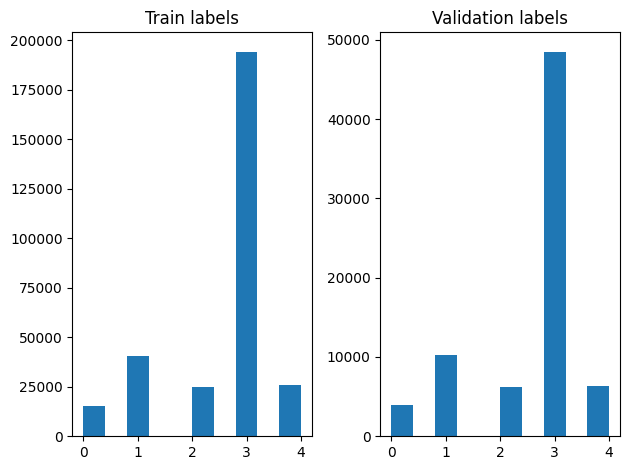

In [13]:
# plot training vs validation distribution
plt.subplot(1, 2, 1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1, 2, 2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

ジェネレータを使用して [Datasete](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) を作成するには、まず `file_paths` から各項目を、ラベル配列からラベルを読み込むジェネレータ関数を書き込み、各ステップ毎にそれぞれ 1 つのトレーニング例を生成します。このジェネレータ関数を [`tf.data.Dataset.from_generator`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) メソッドに渡して出力タイプを指定します。各トレーニング例は、`tf.string` データ型の項目と One-Hot エンコーディングされたラベルを含むタプルです。[`tf.data.Dataset.skip`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip) メソッドと[`tf.data.Dataset.take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) メソッドを使用して、データセットは 80 対 20 の割合でトレーニングデータと検証データに分割しています。

In [14]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [15]:
def make_datasets(train_size):
  batch_size = 256

  train_files = file_paths[:train_size]
  train_labels = labels[:train_size]
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


  return train_ds, test_ds

In [16]:
train_data, validation_data = make_datasets(train_size)

# モデルのトレーニングと評価

既にモジュールの周りにラッパーを追加し、Keras の他のレイヤーと同じように使用できるようになったので、レイヤーの線形スタックである小さな [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) モデルを作成します。他のレイヤーと同様に `model.add` を使用して、テキスト埋め込みモジュールの追加が可能です。損失とオプティマイザを指定してモデルをコンパイルし、10 エポック分をトレーニングします。`tf.keras` API はテンソルフローのデータセットを入力として扱うことができるので、fit メソッドに Dataset インスタンスを渡してモデルをトレーニングすることができます。ジェネレータ関数を使用するので、`tf.data` がサンプルの生成、バッチ処理、モデルへの供給を行います。

## モデル

In [17]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
  ])
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])
  return model

In [18]:
model = create_model()
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## トレーニング

In [19]:
history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs=5, 
                    callbacks=[early_stopping_callback])

Epoch 1/5


   1/1176 [..............................] - ETA: 35:58 - loss: 1.6508 - accuracy: 0.1211

   4/1176 [..............................] - ETA: 23s - loss: 1.5749 - accuracy: 0.1328  

   7/1176 [..............................] - ETA: 22s - loss: 1.5137 - accuracy: 0.1708

  10/1176 [..............................] - ETA: 22s - loss: 1.4514 - accuracy: 0.2797

  13/1176 [..............................] - ETA: 21s - loss: 1.3996 - accuracy: 0.3849

  16/1176 [..............................] - ETA: 21s - loss: 1.3578 - accuracy: 0.4395

  19/1176 [..............................] - ETA: 20s - loss: 1.3117 - accuracy: 0.4807

  22/1176 [..............................] - ETA: 20s - loss: 1.2654 - accuracy: 0.5098

  25/1176 [..............................] - ETA: 20s - loss: 1.2312 - accuracy: 0.5289

  28/1176 [..............................] - ETA: 20s - loss: 1.1989 - accuracy: 0.5466

  31/1176 [..............................] - ETA: 20s - loss: 1.1654 - accuracy: 0.5646

  34/1176 [..............................] - ETA: 20s - loss: 1.1329 - accuracy: 0.5824

  37/1176 [..............................] - ETA: 20s - loss: 1.1035 - accuracy: 0.5972

  40/1176 [>.............................] - ETA: 20s - loss: 1.0732 - accuracy: 0.6111

  43/1176 [>.............................] - ETA: 20s - loss: 1.0459 - accuracy: 0.6223

  47/1176 [>.............................] - ETA: 20s - loss: 1.0094 - accuracy: 0.6375

  50/1176 [>.............................] - ETA: 20s - loss: 0.9866 - accuracy: 0.6477

  53/1176 [>.............................] - ETA: 19s - loss: 0.9619 - accuracy: 0.6589

  56/1176 [>.............................] - ETA: 19s - loss: 0.9381 - accuracy: 0.6687

  59/1176 [>.............................] - ETA: 19s - loss: 0.9205 - accuracy: 0.6747

  62/1176 [>.............................] - ETA: 19s - loss: 0.9011 - accuracy: 0.6828

  66/1176 [>.............................] - ETA: 19s - loss: 0.8766 - accuracy: 0.6934

  69/1176 [>.............................] - ETA: 19s - loss: 0.8566 - accuracy: 0.7013

  72/1176 [>.............................] - ETA: 19s - loss: 0.8382 - accuracy: 0.7088

  75/1176 [>.............................] - ETA: 19s - loss: 0.8226 - accuracy: 0.7152

  78/1176 [>.............................] - ETA: 19s - loss: 0.8065 - accuracy: 0.7215

  81/1176 [=>............................] - ETA: 19s - loss: 0.7907 - accuracy: 0.7272

  84/1176 [=>............................] - ETA: 19s - loss: 0.7753 - accuracy: 0.7326

  88/1176 [=>............................] - ETA: 19s - loss: 0.7573 - accuracy: 0.7392

  91/1176 [=>............................] - ETA: 18s - loss: 0.7434 - accuracy: 0.7442

  94/1176 [=>............................] - ETA: 18s - loss: 0.7308 - accuracy: 0.7489

  97/1176 [=>............................] - ETA: 18s - loss: 0.7188 - accuracy: 0.7533

 100/1176 [=>............................] - ETA: 18s - loss: 0.7072 - accuracy: 0.7577

 103/1176 [=>............................] - ETA: 18s - loss: 0.6954 - accuracy: 0.7622

 106/1176 [=>............................] - ETA: 18s - loss: 0.6845 - accuracy: 0.7662

 109/1176 [=>............................] - ETA: 18s - loss: 0.6752 - accuracy: 0.7696

 112/1176 [=>............................] - ETA: 18s - loss: 0.6656 - accuracy: 0.7728

 116/1176 [=>............................] - ETA: 18s - loss: 0.6529 - accuracy: 0.7775

 120/1176 [==>...........................] - ETA: 18s - loss: 0.6401 - accuracy: 0.7823

 123/1176 [==>...........................] - ETA: 18s - loss: 0.6314 - accuracy: 0.7853

 126/1176 [==>...........................] - ETA: 18s - loss: 0.6231 - accuracy: 0.7881

 129/1176 [==>...........................] - ETA: 18s - loss: 0.6153 - accuracy: 0.7909

 132/1176 [==>...........................] - ETA: 18s - loss: 0.6075 - accuracy: 0.7939

 135/1176 [==>...........................] - ETA: 18s - loss: 0.5999 - accuracy: 0.7966

 138/1176 [==>...........................] - ETA: 18s - loss: 0.5932 - accuracy: 0.7990

 141/1176 [==>...........................] - ETA: 17s - loss: 0.5860 - accuracy: 0.8016

 145/1176 [==>...........................] - ETA: 17s - loss: 0.5767 - accuracy: 0.8048

 148/1176 [==>...........................] - ETA: 17s - loss: 0.5703 - accuracy: 0.8072

 151/1176 [==>...........................] - ETA: 17s - loss: 0.5638 - accuracy: 0.8095

 154/1176 [==>...........................] - ETA: 17s - loss: 0.5572 - accuracy: 0.8118

 157/1176 [===>..........................] - ETA: 17s - loss: 0.5508 - accuracy: 0.8142

 161/1176 [===>..........................] - ETA: 17s - loss: 0.5432 - accuracy: 0.8168

 165/1176 [===>..........................] - ETA: 17s - loss: 0.5355 - accuracy: 0.8195

 168/1176 [===>..........................] - ETA: 17s - loss: 0.5304 - accuracy: 0.8211

 172/1176 [===>..........................] - ETA: 17s - loss: 0.5238 - accuracy: 0.8234

 176/1176 [===>..........................] - ETA: 17s - loss: 0.5170 - accuracy: 0.8261

 179/1176 [===>..........................] - ETA: 17s - loss: 0.5125 - accuracy: 0.8275

 182/1176 [===>..........................] - ETA: 17s - loss: 0.5085 - accuracy: 0.8289

 186/1176 [===>..........................] - ETA: 17s - loss: 0.5019 - accuracy: 0.8312

 189/1176 [===>..........................] - ETA: 17s - loss: 0.4979 - accuracy: 0.8326

 192/1176 [===>..........................] - ETA: 16s - loss: 0.4935 - accuracy: 0.8340

 196/1176 [====>.........................] - ETA: 16s - loss: 0.4883 - accuracy: 0.8359

 200/1176 [====>.........................] - ETA: 16s - loss: 0.4832 - accuracy: 0.8376

 204/1176 [====>.........................] - ETA: 16s - loss: 0.4784 - accuracy: 0.8395

 207/1176 [====>.........................] - ETA: 16s - loss: 0.4744 - accuracy: 0.8411

 210/1176 [====>.........................] - ETA: 16s - loss: 0.4706 - accuracy: 0.8422

 213/1176 [====>.........................] - ETA: 16s - loss: 0.4677 - accuracy: 0.8432

 216/1176 [====>.........................] - ETA: 16s - loss: 0.4642 - accuracy: 0.8443

 219/1176 [====>.........................] - ETA: 16s - loss: 0.4609 - accuracy: 0.8456

 222/1176 [====>.........................] - ETA: 16s - loss: 0.4570 - accuracy: 0.8469

 226/1176 [====>.........................] - ETA: 16s - loss: 0.4527 - accuracy: 0.8483

 230/1176 [====>.........................] - ETA: 16s - loss: 0.4484 - accuracy: 0.8497

 233/1176 [====>.........................] - ETA: 16s - loss: 0.4450 - accuracy: 0.8508

 236/1176 [=====>........................] - ETA: 16s - loss: 0.4416 - accuracy: 0.8519

 239/1176 [=====>........................] - ETA: 16s - loss: 0.4385 - accuracy: 0.8531

 243/1176 [=====>........................] - ETA: 16s - loss: 0.4352 - accuracy: 0.8542

 247/1176 [=====>........................] - ETA: 15s - loss: 0.4319 - accuracy: 0.8554

 250/1176 [=====>........................] - ETA: 15s - loss: 0.4291 - accuracy: 0.8563

 254/1176 [=====>........................] - ETA: 15s - loss: 0.4257 - accuracy: 0.8574

 258/1176 [=====>........................] - ETA: 15s - loss: 0.4225 - accuracy: 0.8585

 261/1176 [=====>........................] - ETA: 15s - loss: 0.4199 - accuracy: 0.8595

 264/1176 [=====>........................] - ETA: 15s - loss: 0.4177 - accuracy: 0.8602

 267/1176 [=====>........................] - ETA: 15s - loss: 0.4152 - accuracy: 0.8610

 270/1176 [=====>........................] - ETA: 15s - loss: 0.4127 - accuracy: 0.8619

 273/1176 [=====>........................] - ETA: 15s - loss: 0.4103 - accuracy: 0.8628

 276/1176 [======>.......................] - ETA: 15s - loss: 0.4080 - accuracy: 0.8636

 279/1176 [======>.......................] - ETA: 15s - loss: 0.4058 - accuracy: 0.8644

 282/1176 [======>.......................] - ETA: 15s - loss: 0.4035 - accuracy: 0.8652

 285/1176 [======>.......................] - ETA: 15s - loss: 0.4013 - accuracy: 0.8661

 288/1176 [======>.......................] - ETA: 15s - loss: 0.3988 - accuracy: 0.8669

 291/1176 [======>.......................] - ETA: 15s - loss: 0.3970 - accuracy: 0.8675

 294/1176 [======>.......................] - ETA: 15s - loss: 0.3951 - accuracy: 0.8681

 297/1176 [======>.......................] - ETA: 15s - loss: 0.3932 - accuracy: 0.8687

 301/1176 [======>.......................] - ETA: 15s - loss: 0.3904 - accuracy: 0.8697

 305/1176 [======>.......................] - ETA: 14s - loss: 0.3881 - accuracy: 0.8705

 309/1176 [======>.......................] - ETA: 14s - loss: 0.3854 - accuracy: 0.8715

 313/1176 [======>.......................] - ETA: 14s - loss: 0.3830 - accuracy: 0.8724

 316/1176 [=======>......................] - ETA: 14s - loss: 0.3811 - accuracy: 0.8731

 319/1176 [=======>......................] - ETA: 14s - loss: 0.3793 - accuracy: 0.8736

 322/1176 [=======>......................] - ETA: 14s - loss: 0.3770 - accuracy: 0.8743

 325/1176 [=======>......................] - ETA: 14s - loss: 0.3752 - accuracy: 0.8749

 328/1176 [=======>......................] - ETA: 14s - loss: 0.3735 - accuracy: 0.8755

 331/1176 [=======>......................] - ETA: 14s - loss: 0.3720 - accuracy: 0.8760

 334/1176 [=======>......................] - ETA: 14s - loss: 0.3703 - accuracy: 0.8765

 337/1176 [=======>......................] - ETA: 14s - loss: 0.3685 - accuracy: 0.8771

 340/1176 [=======>......................] - ETA: 14s - loss: 0.3670 - accuracy: 0.8776

 343/1176 [=======>......................] - ETA: 14s - loss: 0.3655 - accuracy: 0.8781

 346/1176 [=======>......................] - ETA: 14s - loss: 0.3641 - accuracy: 0.8784

 349/1176 [=======>......................] - ETA: 14s - loss: 0.3628 - accuracy: 0.8789

 352/1176 [=======>......................] - ETA: 14s - loss: 0.3613 - accuracy: 0.8794

 355/1176 [========>.....................] - ETA: 14s - loss: 0.3596 - accuracy: 0.8800

 359/1176 [========>.....................] - ETA: 14s - loss: 0.3577 - accuracy: 0.8807

 362/1176 [========>.....................] - ETA: 13s - loss: 0.3565 - accuracy: 0.8810

 366/1176 [========>.....................] - ETA: 13s - loss: 0.3547 - accuracy: 0.8817

 369/1176 [========>.....................] - ETA: 13s - loss: 0.3531 - accuracy: 0.8822

 373/1176 [========>.....................] - ETA: 13s - loss: 0.3513 - accuracy: 0.8829

 377/1176 [========>.....................] - ETA: 13s - loss: 0.3497 - accuracy: 0.8834

 380/1176 [========>.....................] - ETA: 13s - loss: 0.3483 - accuracy: 0.8840

 383/1176 [========>.....................] - ETA: 13s - loss: 0.3470 - accuracy: 0.8844

 386/1176 [========>.....................] - ETA: 13s - loss: 0.3454 - accuracy: 0.8849

 390/1176 [========>.....................] - ETA: 13s - loss: 0.3437 - accuracy: 0.8855

 393/1176 [=========>....................] - ETA: 13s - loss: 0.3426 - accuracy: 0.8858

 396/1176 [=========>....................] - ETA: 13s - loss: 0.3414 - accuracy: 0.8864

 399/1176 [=========>....................] - ETA: 13s - loss: 0.3401 - accuracy: 0.8868

 402/1176 [=========>....................] - ETA: 13s - loss: 0.3388 - accuracy: 0.8872

 405/1176 [=========>....................] - ETA: 13s - loss: 0.3376 - accuracy: 0.8875

 408/1176 [=========>....................] - ETA: 13s - loss: 0.3365 - accuracy: 0.8878

 411/1176 [=========>....................] - ETA: 13s - loss: 0.3355 - accuracy: 0.8883

 414/1176 [=========>....................] - ETA: 13s - loss: 0.3344 - accuracy: 0.8887

 417/1176 [=========>....................] - ETA: 13s - loss: 0.3333 - accuracy: 0.8891

 420/1176 [=========>....................] - ETA: 13s - loss: 0.3321 - accuracy: 0.8896

 423/1176 [=========>....................] - ETA: 12s - loss: 0.3310 - accuracy: 0.8900

 427/1176 [=========>....................] - ETA: 12s - loss: 0.3300 - accuracy: 0.8902

 430/1176 [=========>....................] - ETA: 12s - loss: 0.3289 - accuracy: 0.8906

 433/1176 [==========>...................] - ETA: 12s - loss: 0.3280 - accuracy: 0.8909

 437/1176 [==========>...................] - ETA: 12s - loss: 0.3267 - accuracy: 0.8914

 440/1176 [==========>...................] - ETA: 12s - loss: 0.3258 - accuracy: 0.8916

 443/1176 [==========>...................] - ETA: 12s - loss: 0.3246 - accuracy: 0.8920

 446/1176 [==========>...................] - ETA: 12s - loss: 0.3234 - accuracy: 0.8924

 449/1176 [==========>...................] - ETA: 12s - loss: 0.3226 - accuracy: 0.8927

 452/1176 [==========>...................] - ETA: 12s - loss: 0.3214 - accuracy: 0.8931

 455/1176 [==========>...................] - ETA: 12s - loss: 0.3205 - accuracy: 0.8934

 458/1176 [==========>...................] - ETA: 12s - loss: 0.3196 - accuracy: 0.8937

 461/1176 [==========>...................] - ETA: 12s - loss: 0.3187 - accuracy: 0.8940

 464/1176 [==========>...................] - ETA: 12s - loss: 0.3179 - accuracy: 0.8942

 467/1176 [==========>...................] - ETA: 12s - loss: 0.3171 - accuracy: 0.8945

 470/1176 [==========>...................] - ETA: 12s - loss: 0.3161 - accuracy: 0.8948

 473/1176 [===========>..................] - ETA: 12s - loss: 0.3154 - accuracy: 0.8951

 476/1176 [===========>..................] - ETA: 12s - loss: 0.3146 - accuracy: 0.8953

 479/1176 [===========>..................] - ETA: 12s - loss: 0.3138 - accuracy: 0.8955

 482/1176 [===========>..................] - ETA: 11s - loss: 0.3127 - accuracy: 0.8959

 485/1176 [===========>..................] - ETA: 11s - loss: 0.3119 - accuracy: 0.8962

 488/1176 [===========>..................] - ETA: 11s - loss: 0.3109 - accuracy: 0.8965

 491/1176 [===========>..................] - ETA: 11s - loss: 0.3102 - accuracy: 0.8967

 494/1176 [===========>..................] - ETA: 11s - loss: 0.3095 - accuracy: 0.8969

 498/1176 [===========>..................] - ETA: 11s - loss: 0.3085 - accuracy: 0.8972

 502/1176 [===========>..................] - ETA: 11s - loss: 0.3075 - accuracy: 0.8976

 505/1176 [===========>..................] - ETA: 11s - loss: 0.3066 - accuracy: 0.8979

 508/1176 [===========>..................] - ETA: 11s - loss: 0.3058 - accuracy: 0.8981

 511/1176 [============>.................] - ETA: 11s - loss: 0.3049 - accuracy: 0.8985

 514/1176 [============>.................] - ETA: 11s - loss: 0.3042 - accuracy: 0.8987

 517/1176 [============>.................] - ETA: 11s - loss: 0.3037 - accuracy: 0.8988

 520/1176 [============>.................] - ETA: 11s - loss: 0.3030 - accuracy: 0.8990

 523/1176 [============>.................] - ETA: 11s - loss: 0.3025 - accuracy: 0.8992

 526/1176 [============>.................] - ETA: 11s - loss: 0.3019 - accuracy: 0.8995

 530/1176 [============>.................] - ETA: 11s - loss: 0.3009 - accuracy: 0.8998

 534/1176 [============>.................] - ETA: 11s - loss: 0.2997 - accuracy: 0.9002

 537/1176 [============>.................] - ETA: 11s - loss: 0.2990 - accuracy: 0.9004

 540/1176 [============>.................] - ETA: 11s - loss: 0.2984 - accuracy: 0.9007

 543/1176 [============>.................] - ETA: 10s - loss: 0.2977 - accuracy: 0.9009

 546/1176 [============>.................] - ETA: 10s - loss: 0.2971 - accuracy: 0.9011

 549/1176 [=============>................] - ETA: 10s - loss: 0.2964 - accuracy: 0.9013

 552/1176 [=============>................] - ETA: 10s - loss: 0.2960 - accuracy: 0.9014

 555/1176 [=============>................] - ETA: 10s - loss: 0.2953 - accuracy: 0.9017

 558/1176 [=============>................] - ETA: 10s - loss: 0.2948 - accuracy: 0.9019

 561/1176 [=============>................] - ETA: 10s - loss: 0.2943 - accuracy: 0.9020

 564/1176 [=============>................] - ETA: 10s - loss: 0.2935 - accuracy: 0.9023

 567/1176 [=============>................] - ETA: 10s - loss: 0.2928 - accuracy: 0.9025

 570/1176 [=============>................] - ETA: 10s - loss: 0.2921 - accuracy: 0.9028

 573/1176 [=============>................] - ETA: 10s - loss: 0.2914 - accuracy: 0.9030

 576/1176 [=============>................] - ETA: 10s - loss: 0.2907 - accuracy: 0.9032

 579/1176 [=============>................] - ETA: 10s - loss: 0.2902 - accuracy: 0.9033

 582/1176 [=============>................] - ETA: 10s - loss: 0.2898 - accuracy: 0.9035

 585/1176 [=============>................] - ETA: 10s - loss: 0.2892 - accuracy: 0.9037

 588/1176 [==============>...............] - ETA: 10s - loss: 0.2885 - accuracy: 0.9039

 591/1176 [==============>...............] - ETA: 10s - loss: 0.2880 - accuracy: 0.9040

 594/1176 [==============>...............] - ETA: 10s - loss: 0.2874 - accuracy: 0.9042

 597/1176 [==============>...............] - ETA: 10s - loss: 0.2868 - accuracy: 0.9044

 600/1176 [==============>...............] - ETA: 10s - loss: 0.2864 - accuracy: 0.9045

 603/1176 [==============>...............] - ETA: 9s - loss: 0.2856 - accuracy: 0.9047 

 606/1176 [==============>...............] - ETA: 9s - loss: 0.2850 - accuracy: 0.9049

 609/1176 [==============>...............] - ETA: 9s - loss: 0.2845 - accuracy: 0.9051

 612/1176 [==============>...............] - ETA: 9s - loss: 0.2838 - accuracy: 0.9053

 615/1176 [==============>...............] - ETA: 9s - loss: 0.2832 - accuracy: 0.9055

 618/1176 [==============>...............] - ETA: 9s - loss: 0.2826 - accuracy: 0.9057

 621/1176 [==============>...............] - ETA: 9s - loss: 0.2820 - accuracy: 0.9059

 624/1176 [==============>...............] - ETA: 9s - loss: 0.2816 - accuracy: 0.9060

 627/1176 [==============>...............] - ETA: 9s - loss: 0.2810 - accuracy: 0.9062

 630/1176 [===============>..............] - ETA: 9s - loss: 0.2806 - accuracy: 0.9063

 633/1176 [===============>..............] - ETA: 9s - loss: 0.2802 - accuracy: 0.9064

 636/1176 [===============>..............] - ETA: 9s - loss: 0.2797 - accuracy: 0.9066

 640/1176 [===============>..............] - ETA: 9s - loss: 0.2789 - accuracy: 0.9069

 643/1176 [===============>..............] - ETA: 9s - loss: 0.2785 - accuracy: 0.9070

 646/1176 [===============>..............] - ETA: 9s - loss: 0.2779 - accuracy: 0.9072

 649/1176 [===============>..............] - ETA: 9s - loss: 0.2773 - accuracy: 0.9074

 652/1176 [===============>..............] - ETA: 9s - loss: 0.2767 - accuracy: 0.9076

 655/1176 [===============>..............] - ETA: 9s - loss: 0.2761 - accuracy: 0.9078

 658/1176 [===============>..............] - ETA: 9s - loss: 0.2758 - accuracy: 0.9079

 661/1176 [===============>..............] - ETA: 8s - loss: 0.2754 - accuracy: 0.9080

 664/1176 [===============>..............] - ETA: 8s - loss: 0.2747 - accuracy: 0.9082

 667/1176 [================>.............] - ETA: 8s - loss: 0.2742 - accuracy: 0.9084

 670/1176 [================>.............] - ETA: 8s - loss: 0.2738 - accuracy: 0.9085

 673/1176 [================>.............] - ETA: 8s - loss: 0.2733 - accuracy: 0.9087

 676/1176 [================>.............] - ETA: 8s - loss: 0.2728 - accuracy: 0.9089

 679/1176 [================>.............] - ETA: 8s - loss: 0.2724 - accuracy: 0.9090

 682/1176 [================>.............] - ETA: 8s - loss: 0.2720 - accuracy: 0.9091

 685/1176 [================>.............] - ETA: 8s - loss: 0.2713 - accuracy: 0.9093

 688/1176 [================>.............] - ETA: 8s - loss: 0.2709 - accuracy: 0.9095

 691/1176 [================>.............] - ETA: 8s - loss: 0.2704 - accuracy: 0.9096

 694/1176 [================>.............] - ETA: 8s - loss: 0.2699 - accuracy: 0.9097

 697/1176 [================>.............] - ETA: 8s - loss: 0.2692 - accuracy: 0.9100

 700/1176 [================>.............] - ETA: 8s - loss: 0.2686 - accuracy: 0.9101

 703/1176 [================>.............] - ETA: 8s - loss: 0.2683 - accuracy: 0.9102

 706/1176 [=================>............] - ETA: 8s - loss: 0.2680 - accuracy: 0.9103

 709/1176 [=================>............] - ETA: 8s - loss: 0.2675 - accuracy: 0.9105

 712/1176 [=================>............] - ETA: 8s - loss: 0.2671 - accuracy: 0.9106

 715/1176 [=================>............] - ETA: 8s - loss: 0.2667 - accuracy: 0.9108

 718/1176 [=================>............] - ETA: 7s - loss: 0.2664 - accuracy: 0.9109

 721/1176 [=================>............] - ETA: 7s - loss: 0.2659 - accuracy: 0.9110

 724/1176 [=================>............] - ETA: 7s - loss: 0.2657 - accuracy: 0.9112

 728/1176 [=================>............] - ETA: 7s - loss: 0.2651 - accuracy: 0.9113

 731/1176 [=================>............] - ETA: 7s - loss: 0.2648 - accuracy: 0.9114

 734/1176 [=================>............] - ETA: 7s - loss: 0.2644 - accuracy: 0.9116

 738/1176 [=================>............] - ETA: 7s - loss: 0.2640 - accuracy: 0.9117

 741/1176 [=================>............] - ETA: 7s - loss: 0.2635 - accuracy: 0.9119

 744/1176 [=================>............] - ETA: 7s - loss: 0.2631 - accuracy: 0.9120

 747/1176 [==================>...........] - ETA: 7s - loss: 0.2628 - accuracy: 0.9122

 750/1176 [==================>...........] - ETA: 7s - loss: 0.2624 - accuracy: 0.9123

 753/1176 [==================>...........] - ETA: 7s - loss: 0.2619 - accuracy: 0.9125

 756/1176 [==================>...........] - ETA: 7s - loss: 0.2617 - accuracy: 0.9126

 759/1176 [==================>...........] - ETA: 7s - loss: 0.2613 - accuracy: 0.9127

 762/1176 [==================>...........] - ETA: 7s - loss: 0.2609 - accuracy: 0.9128

 765/1176 [==================>...........] - ETA: 7s - loss: 0.2606 - accuracy: 0.9129

 768/1176 [==================>...........] - ETA: 7s - loss: 0.2604 - accuracy: 0.9130

 771/1176 [==================>...........] - ETA: 7s - loss: 0.2601 - accuracy: 0.9131

 774/1176 [==================>...........] - ETA: 7s - loss: 0.2598 - accuracy: 0.9132

 777/1176 [==================>...........] - ETA: 6s - loss: 0.2594 - accuracy: 0.9133

 780/1176 [==================>...........] - ETA: 6s - loss: 0.2590 - accuracy: 0.9134

 783/1176 [==================>...........] - ETA: 6s - loss: 0.2587 - accuracy: 0.9135

 786/1176 [===================>..........] - ETA: 6s - loss: 0.2583 - accuracy: 0.9137

 789/1176 [===================>..........] - ETA: 6s - loss: 0.2581 - accuracy: 0.9137

 792/1176 [===================>..........] - ETA: 6s - loss: 0.2578 - accuracy: 0.9139

 795/1176 [===================>..........] - ETA: 6s - loss: 0.2573 - accuracy: 0.9140

 798/1176 [===================>..........] - ETA: 6s - loss: 0.2569 - accuracy: 0.9142

 801/1176 [===================>..........] - ETA: 6s - loss: 0.2564 - accuracy: 0.9143

 804/1176 [===================>..........] - ETA: 6s - loss: 0.2561 - accuracy: 0.9143

 808/1176 [===================>..........] - ETA: 6s - loss: 0.2554 - accuracy: 0.9146

 811/1176 [===================>..........] - ETA: 6s - loss: 0.2552 - accuracy: 0.9146

 814/1176 [===================>..........] - ETA: 6s - loss: 0.2550 - accuracy: 0.9147

 817/1176 [===================>..........] - ETA: 6s - loss: 0.2546 - accuracy: 0.9149

 821/1176 [===================>..........] - ETA: 6s - loss: 0.2542 - accuracy: 0.9150

 824/1176 [====================>.........] - ETA: 6s - loss: 0.2539 - accuracy: 0.9150

 827/1176 [====================>.........] - ETA: 6s - loss: 0.2536 - accuracy: 0.9152

 830/1176 [====================>.........] - ETA: 6s - loss: 0.2531 - accuracy: 0.9154

 833/1176 [====================>.........] - ETA: 5s - loss: 0.2527 - accuracy: 0.9155

 836/1176 [====================>.........] - ETA: 5s - loss: 0.2523 - accuracy: 0.9157

 839/1176 [====================>.........] - ETA: 5s - loss: 0.2520 - accuracy: 0.9157

 842/1176 [====================>.........] - ETA: 5s - loss: 0.2518 - accuracy: 0.9158

 845/1176 [====================>.........] - ETA: 5s - loss: 0.2513 - accuracy: 0.9160

 848/1176 [====================>.........] - ETA: 5s - loss: 0.2510 - accuracy: 0.9160

 851/1176 [====================>.........] - ETA: 5s - loss: 0.2506 - accuracy: 0.9161

 854/1176 [====================>.........] - ETA: 5s - loss: 0.2505 - accuracy: 0.9162

 857/1176 [====================>.........] - ETA: 5s - loss: 0.2500 - accuracy: 0.9163

 860/1176 [====================>.........] - ETA: 5s - loss: 0.2498 - accuracy: 0.9164

 863/1176 [=====================>........] - ETA: 5s - loss: 0.2494 - accuracy: 0.9165

 866/1176 [=====================>........] - ETA: 5s - loss: 0.2492 - accuracy: 0.9166

 869/1176 [=====================>........] - ETA: 5s - loss: 0.2489 - accuracy: 0.9167

 873/1176 [=====================>........] - ETA: 5s - loss: 0.2485 - accuracy: 0.9168

 876/1176 [=====================>........] - ETA: 5s - loss: 0.2481 - accuracy: 0.9169

 879/1176 [=====================>........] - ETA: 5s - loss: 0.2478 - accuracy: 0.9171

 882/1176 [=====================>........] - ETA: 5s - loss: 0.2475 - accuracy: 0.9172

 885/1176 [=====================>........] - ETA: 5s - loss: 0.2471 - accuracy: 0.9173

 888/1176 [=====================>........] - ETA: 5s - loss: 0.2468 - accuracy: 0.9174

 891/1176 [=====================>........] - ETA: 4s - loss: 0.2466 - accuracy: 0.9174

 894/1176 [=====================>........] - ETA: 4s - loss: 0.2463 - accuracy: 0.9175

 897/1176 [=====================>........] - ETA: 4s - loss: 0.2461 - accuracy: 0.9176

 900/1176 [=====================>........] - ETA: 4s - loss: 0.2458 - accuracy: 0.9177

 903/1176 [======================>.......] - ETA: 4s - loss: 0.2457 - accuracy: 0.9178

 906/1176 [======================>.......] - ETA: 4s - loss: 0.2454 - accuracy: 0.9178

 909/1176 [======================>.......] - ETA: 4s - loss: 0.2452 - accuracy: 0.9179

 913/1176 [======================>.......] - ETA: 4s - loss: 0.2448 - accuracy: 0.9181

 916/1176 [======================>.......] - ETA: 4s - loss: 0.2446 - accuracy: 0.9181

 919/1176 [======================>.......] - ETA: 4s - loss: 0.2442 - accuracy: 0.9183

 922/1176 [======================>.......] - ETA: 4s - loss: 0.2439 - accuracy: 0.9183

 925/1176 [======================>.......] - ETA: 4s - loss: 0.2436 - accuracy: 0.9185

 928/1176 [======================>.......] - ETA: 4s - loss: 0.2434 - accuracy: 0.9185

 931/1176 [======================>.......] - ETA: 4s - loss: 0.2431 - accuracy: 0.9186

 934/1176 [======================>.......] - ETA: 4s - loss: 0.2428 - accuracy: 0.9187

 937/1176 [======================>.......] - ETA: 4s - loss: 0.2426 - accuracy: 0.9188

 940/1176 [======================>.......] - ETA: 4s - loss: 0.2422 - accuracy: 0.9189

 943/1176 [=======================>......] - ETA: 4s - loss: 0.2419 - accuracy: 0.9190

 946/1176 [=======================>......] - ETA: 4s - loss: 0.2416 - accuracy: 0.9191

 949/1176 [=======================>......] - ETA: 3s - loss: 0.2412 - accuracy: 0.9192

 952/1176 [=======================>......] - ETA: 3s - loss: 0.2409 - accuracy: 0.9193

 955/1176 [=======================>......] - ETA: 3s - loss: 0.2407 - accuracy: 0.9194

 958/1176 [=======================>......] - ETA: 3s - loss: 0.2403 - accuracy: 0.9195

 961/1176 [=======================>......] - ETA: 3s - loss: 0.2400 - accuracy: 0.9195

 964/1176 [=======================>......] - ETA: 3s - loss: 0.2398 - accuracy: 0.9197

 968/1176 [=======================>......] - ETA: 3s - loss: 0.2394 - accuracy: 0.9198

 971/1176 [=======================>......] - ETA: 3s - loss: 0.2392 - accuracy: 0.9199

 974/1176 [=======================>......] - ETA: 3s - loss: 0.2389 - accuracy: 0.9200

 977/1176 [=======================>......] - ETA: 3s - loss: 0.2386 - accuracy: 0.9201

 980/1176 [========================>.....] - ETA: 3s - loss: 0.2382 - accuracy: 0.9202

 983/1176 [========================>.....] - ETA: 3s - loss: 0.2380 - accuracy: 0.9203

 987/1176 [========================>.....] - ETA: 3s - loss: 0.2376 - accuracy: 0.9204

 990/1176 [========================>.....] - ETA: 3s - loss: 0.2373 - accuracy: 0.9205

 993/1176 [========================>.....] - ETA: 3s - loss: 0.2371 - accuracy: 0.9206

 996/1176 [========================>.....] - ETA: 3s - loss: 0.2369 - accuracy: 0.9206

 999/1176 [========================>.....] - ETA: 3s - loss: 0.2366 - accuracy: 0.9207

1002/1176 [========================>.....] - ETA: 3s - loss: 0.2363 - accuracy: 0.9208

1005/1176 [========================>.....] - ETA: 2s - loss: 0.2361 - accuracy: 0.9209

1008/1176 [========================>.....] - ETA: 2s - loss: 0.2359 - accuracy: 0.9209

1011/1176 [========================>.....] - ETA: 2s - loss: 0.2356 - accuracy: 0.9210

1014/1176 [========================>.....] - ETA: 2s - loss: 0.2354 - accuracy: 0.9211

1017/1176 [========================>.....] - ETA: 2s - loss: 0.2352 - accuracy: 0.9211

1020/1176 [=========================>....] - ETA: 2s - loss: 0.2351 - accuracy: 0.9211

1023/1176 [=========================>....] - ETA: 2s - loss: 0.2348 - accuracy: 0.9212

1026/1176 [=========================>....] - ETA: 2s - loss: 0.2346 - accuracy: 0.9213

1029/1176 [=========================>....] - ETA: 2s - loss: 0.2345 - accuracy: 0.9213

1032/1176 [=========================>....] - ETA: 2s - loss: 0.2343 - accuracy: 0.9214

1035/1176 [=========================>....] - ETA: 2s - loss: 0.2340 - accuracy: 0.9215

1038/1176 [=========================>....] - ETA: 2s - loss: 0.2338 - accuracy: 0.9215

1041/1176 [=========================>....] - ETA: 2s - loss: 0.2336 - accuracy: 0.9216

1045/1176 [=========================>....] - ETA: 2s - loss: 0.2332 - accuracy: 0.9217

1049/1176 [=========================>....] - ETA: 2s - loss: 0.2330 - accuracy: 0.9218

1052/1176 [=========================>....] - ETA: 2s - loss: 0.2328 - accuracy: 0.9218

1055/1176 [=========================>....] - ETA: 2s - loss: 0.2326 - accuracy: 0.9219

1058/1176 [=========================>....] - ETA: 2s - loss: 0.2324 - accuracy: 0.9220

1062/1176 [==========================>...] - ETA: 1s - loss: 0.2321 - accuracy: 0.9221

1065/1176 [==========================>...] - ETA: 1s - loss: 0.2318 - accuracy: 0.9222

1068/1176 [==========================>...] - ETA: 1s - loss: 0.2316 - accuracy: 0.9223

1071/1176 [==========================>...] - ETA: 1s - loss: 0.2314 - accuracy: 0.9223

1075/1176 [==========================>...] - ETA: 1s - loss: 0.2311 - accuracy: 0.9224

1078/1176 [==========================>...] - ETA: 1s - loss: 0.2308 - accuracy: 0.9225

1081/1176 [==========================>...] - ETA: 1s - loss: 0.2305 - accuracy: 0.9226

1084/1176 [==========================>...] - ETA: 1s - loss: 0.2304 - accuracy: 0.9227

1087/1176 [==========================>...] - ETA: 1s - loss: 0.2302 - accuracy: 0.9228

1090/1176 [==========================>...] - ETA: 1s - loss: 0.2299 - accuracy: 0.9229

1093/1176 [==========================>...] - ETA: 1s - loss: 0.2297 - accuracy: 0.9230

1096/1176 [==========================>...] - ETA: 1s - loss: 0.2294 - accuracy: 0.9231

1099/1176 [===========================>..] - ETA: 1s - loss: 0.2292 - accuracy: 0.9231

1102/1176 [===========================>..] - ETA: 1s - loss: 0.2289 - accuracy: 0.9232

1105/1176 [===========================>..] - ETA: 1s - loss: 0.2286 - accuracy: 0.9233

1108/1176 [===========================>..] - ETA: 1s - loss: 0.2285 - accuracy: 0.9233

1111/1176 [===========================>..] - ETA: 1s - loss: 0.2282 - accuracy: 0.9234

1115/1176 [===========================>..] - ETA: 1s - loss: 0.2280 - accuracy: 0.9235

1118/1176 [===========================>..] - ETA: 1s - loss: 0.2278 - accuracy: 0.9235

1121/1176 [===========================>..] - ETA: 0s - loss: 0.2276 - accuracy: 0.9236

1125/1176 [===========================>..] - ETA: 0s - loss: 0.2274 - accuracy: 0.9237

1128/1176 [===========================>..] - ETA: 0s - loss: 0.2272 - accuracy: 0.9237

1132/1176 [===========================>..] - ETA: 0s - loss: 0.2269 - accuracy: 0.9238

1136/1176 [===========================>..] - ETA: 0s - loss: 0.2267 - accuracy: 0.9239

1139/1176 [============================>.] - ETA: 0s - loss: 0.2265 - accuracy: 0.9240

1142/1176 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9241

1146/1176 [============================>.] - ETA: 0s - loss: 0.2260 - accuracy: 0.9241

1150/1176 [============================>.] - ETA: 0s - loss: 0.2258 - accuracy: 0.9242

1153/1176 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9243

1157/1176 [============================>.] - ETA: 0s - loss: 0.2252 - accuracy: 0.9244

1161/1176 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9244

1164/1176 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9245

1168/1176 [============================>.] - ETA: 0s - loss: 0.2245 - accuracy: 0.9246

1171/1176 [============================>.] - ETA: 0s - loss: 0.2244 - accuracy: 0.9246

1174/1176 [============================>.] - ETA: 0s - loss: 0.2242 - accuracy: 0.9247

1176/1176 [==============================] - 27s 22ms/step - loss: 0.2242 - accuracy: 0.9247 - val_loss: 0.1505 - val_accuracy: 0.9484


Epoch 2/5


   1/1176 [..............................] - ETA: 2:13 - loss: 0.1288 - accuracy: 0.9609

   4/1176 [..............................] - ETA: 20s - loss: 0.1316 - accuracy: 0.9590 

   8/1176 [..............................] - ETA: 19s - loss: 0.1303 - accuracy: 0.9556

  12/1176 [..............................] - ETA: 19s - loss: 0.1400 - accuracy: 0.9505

  15/1176 [..............................] - ETA: 19s - loss: 0.1390 - accuracy: 0.9495

  19/1176 [..............................] - ETA: 19s - loss: 0.1469 - accuracy: 0.9463

  22/1176 [..............................] - ETA: 19s - loss: 0.1473 - accuracy: 0.9458

  25/1176 [..............................] - ETA: 19s - loss: 0.1441 - accuracy: 0.9470

  28/1176 [..............................] - ETA: 19s - loss: 0.1468 - accuracy: 0.9480

  32/1176 [..............................] - ETA: 19s - loss: 0.1455 - accuracy: 0.9485

  35/1176 [..............................] - ETA: 19s - loss: 0.1443 - accuracy: 0.9484

  39/1176 [..............................] - ETA: 18s - loss: 0.1452 - accuracy: 0.9483

  42/1176 [>.............................] - ETA: 18s - loss: 0.1459 - accuracy: 0.9479

  45/1176 [>.............................] - ETA: 18s - loss: 0.1448 - accuracy: 0.9476

  48/1176 [>.............................] - ETA: 18s - loss: 0.1444 - accuracy: 0.9478

  52/1176 [>.............................] - ETA: 18s - loss: 0.1438 - accuracy: 0.9479

  55/1176 [>.............................] - ETA: 18s - loss: 0.1483 - accuracy: 0.9472

  59/1176 [>.............................] - ETA: 18s - loss: 0.1465 - accuracy: 0.9478

  63/1176 [>.............................] - ETA: 18s - loss: 0.1478 - accuracy: 0.9475

  66/1176 [>.............................] - ETA: 18s - loss: 0.1472 - accuracy: 0.9476

  70/1176 [>.............................] - ETA: 18s - loss: 0.1478 - accuracy: 0.9474

  74/1176 [>.............................] - ETA: 18s - loss: 0.1474 - accuracy: 0.9475

  78/1176 [>.............................] - ETA: 18s - loss: 0.1481 - accuracy: 0.9472

  82/1176 [=>............................] - ETA: 18s - loss: 0.1480 - accuracy: 0.9471

  85/1176 [=>............................] - ETA: 18s - loss: 0.1481 - accuracy: 0.9473

  89/1176 [=>............................] - ETA: 18s - loss: 0.1486 - accuracy: 0.9468

  93/1176 [=>............................] - ETA: 17s - loss: 0.1481 - accuracy: 0.9471

  97/1176 [=>............................] - ETA: 17s - loss: 0.1463 - accuracy: 0.9478

 101/1176 [=>............................] - ETA: 17s - loss: 0.1472 - accuracy: 0.9477

 104/1176 [=>............................] - ETA: 17s - loss: 0.1470 - accuracy: 0.9477

 108/1176 [=>............................] - ETA: 17s - loss: 0.1462 - accuracy: 0.9480

 111/1176 [=>............................] - ETA: 17s - loss: 0.1470 - accuracy: 0.9477

 114/1176 [=>............................] - ETA: 17s - loss: 0.1467 - accuracy: 0.9479

 117/1176 [=>............................] - ETA: 17s - loss: 0.1465 - accuracy: 0.9480

 121/1176 [==>...........................] - ETA: 17s - loss: 0.1475 - accuracy: 0.9477

 125/1176 [==>...........................] - ETA: 17s - loss: 0.1475 - accuracy: 0.9479

 128/1176 [==>...........................] - ETA: 17s - loss: 0.1472 - accuracy: 0.9482

 132/1176 [==>...........................] - ETA: 17s - loss: 0.1474 - accuracy: 0.9479

 136/1176 [==>...........................] - ETA: 17s - loss: 0.1472 - accuracy: 0.9479

 139/1176 [==>...........................] - ETA: 17s - loss: 0.1476 - accuracy: 0.9478

 143/1176 [==>...........................] - ETA: 17s - loss: 0.1472 - accuracy: 0.9480

 147/1176 [==>...........................] - ETA: 17s - loss: 0.1470 - accuracy: 0.9480

 151/1176 [==>...........................] - ETA: 17s - loss: 0.1474 - accuracy: 0.9478

 154/1176 [==>...........................] - ETA: 16s - loss: 0.1476 - accuracy: 0.9479

 158/1176 [===>..........................] - ETA: 16s - loss: 0.1472 - accuracy: 0.9481

 161/1176 [===>..........................] - ETA: 16s - loss: 0.1468 - accuracy: 0.9482

 164/1176 [===>..........................] - ETA: 16s - loss: 0.1466 - accuracy: 0.9481

 168/1176 [===>..........................] - ETA: 16s - loss: 0.1461 - accuracy: 0.9481

 171/1176 [===>..........................] - ETA: 16s - loss: 0.1465 - accuracy: 0.9481

 175/1176 [===>..........................] - ETA: 16s - loss: 0.1466 - accuracy: 0.9481

 179/1176 [===>..........................] - ETA: 16s - loss: 0.1469 - accuracy: 0.9481

 183/1176 [===>..........................] - ETA: 16s - loss: 0.1471 - accuracy: 0.9481

 186/1176 [===>..........................] - ETA: 16s - loss: 0.1472 - accuracy: 0.9481

 189/1176 [===>..........................] - ETA: 16s - loss: 0.1470 - accuracy: 0.9481

 192/1176 [===>..........................] - ETA: 16s - loss: 0.1471 - accuracy: 0.9480

 195/1176 [===>..........................] - ETA: 16s - loss: 0.1465 - accuracy: 0.9482

 199/1176 [====>.........................] - ETA: 16s - loss: 0.1465 - accuracy: 0.9481

 203/1176 [====>.........................] - ETA: 16s - loss: 0.1464 - accuracy: 0.9483

 206/1176 [====>.........................] - ETA: 16s - loss: 0.1462 - accuracy: 0.9484

 209/1176 [====>.........................] - ETA: 16s - loss: 0.1459 - accuracy: 0.9486

 213/1176 [====>.........................] - ETA: 16s - loss: 0.1462 - accuracy: 0.9486

 216/1176 [====>.........................] - ETA: 15s - loss: 0.1461 - accuracy: 0.9486

 220/1176 [====>.........................] - ETA: 15s - loss: 0.1464 - accuracy: 0.9483

 224/1176 [====>.........................] - ETA: 15s - loss: 0.1465 - accuracy: 0.9483

 227/1176 [====>.........................] - ETA: 15s - loss: 0.1467 - accuracy: 0.9484

 230/1176 [====>.........................] - ETA: 15s - loss: 0.1465 - accuracy: 0.9483

 234/1176 [====>.........................] - ETA: 15s - loss: 0.1470 - accuracy: 0.9481

 238/1176 [=====>........................] - ETA: 15s - loss: 0.1475 - accuracy: 0.9479

 242/1176 [=====>........................] - ETA: 15s - loss: 0.1475 - accuracy: 0.9480

 246/1176 [=====>........................] - ETA: 15s - loss: 0.1468 - accuracy: 0.9482

 250/1176 [=====>........................] - ETA: 15s - loss: 0.1468 - accuracy: 0.9482

 254/1176 [=====>........................] - ETA: 15s - loss: 0.1469 - accuracy: 0.9484

 257/1176 [=====>........................] - ETA: 15s - loss: 0.1469 - accuracy: 0.9484

 261/1176 [=====>........................] - ETA: 15s - loss: 0.1467 - accuracy: 0.9484

 265/1176 [=====>........................] - ETA: 15s - loss: 0.1468 - accuracy: 0.9484

 268/1176 [=====>........................] - ETA: 15s - loss: 0.1467 - accuracy: 0.9484

 272/1176 [=====>........................] - ETA: 14s - loss: 0.1463 - accuracy: 0.9485

 276/1176 [======>.......................] - ETA: 14s - loss: 0.1462 - accuracy: 0.9485

 280/1176 [======>.......................] - ETA: 14s - loss: 0.1462 - accuracy: 0.9486

 283/1176 [======>.......................] - ETA: 14s - loss: 0.1463 - accuracy: 0.9485

 286/1176 [======>.......................] - ETA: 14s - loss: 0.1467 - accuracy: 0.9483

 290/1176 [======>.......................] - ETA: 14s - loss: 0.1463 - accuracy: 0.9485

 294/1176 [======>.......................] - ETA: 14s - loss: 0.1462 - accuracy: 0.9486

 298/1176 [======>.......................] - ETA: 14s - loss: 0.1461 - accuracy: 0.9487

 302/1176 [======>.......................] - ETA: 14s - loss: 0.1465 - accuracy: 0.9486

 305/1176 [======>.......................] - ETA: 14s - loss: 0.1464 - accuracy: 0.9487

 308/1176 [======>.......................] - ETA: 14s - loss: 0.1465 - accuracy: 0.9487

 312/1176 [======>.......................] - ETA: 14s - loss: 0.1463 - accuracy: 0.9487

 316/1176 [=======>......................] - ETA: 14s - loss: 0.1462 - accuracy: 0.9488

 319/1176 [=======>......................] - ETA: 14s - loss: 0.1464 - accuracy: 0.9487

 322/1176 [=======>......................] - ETA: 14s - loss: 0.1466 - accuracy: 0.9486

 325/1176 [=======>......................] - ETA: 14s - loss: 0.1463 - accuracy: 0.9487

 328/1176 [=======>......................] - ETA: 14s - loss: 0.1464 - accuracy: 0.9487

 332/1176 [=======>......................] - ETA: 14s - loss: 0.1465 - accuracy: 0.9486

 336/1176 [=======>......................] - ETA: 13s - loss: 0.1464 - accuracy: 0.9487

 339/1176 [=======>......................] - ETA: 13s - loss: 0.1467 - accuracy: 0.9486

 343/1176 [=======>......................] - ETA: 13s - loss: 0.1468 - accuracy: 0.9486

 347/1176 [=======>......................] - ETA: 13s - loss: 0.1469 - accuracy: 0.9484

 350/1176 [=======>......................] - ETA: 13s - loss: 0.1469 - accuracy: 0.9484

 354/1176 [========>.....................] - ETA: 13s - loss: 0.1467 - accuracy: 0.9485

 358/1176 [========>.....................] - ETA: 13s - loss: 0.1466 - accuracy: 0.9486

 361/1176 [========>.....................] - ETA: 13s - loss: 0.1467 - accuracy: 0.9486

 364/1176 [========>.....................] - ETA: 13s - loss: 0.1466 - accuracy: 0.9485

 367/1176 [========>.....................] - ETA: 13s - loss: 0.1465 - accuracy: 0.9486

 370/1176 [========>.....................] - ETA: 13s - loss: 0.1464 - accuracy: 0.9486

 374/1176 [========>.....................] - ETA: 13s - loss: 0.1466 - accuracy: 0.9486

 377/1176 [========>.....................] - ETA: 13s - loss: 0.1466 - accuracy: 0.9487

 381/1176 [========>.....................] - ETA: 13s - loss: 0.1464 - accuracy: 0.9487

 385/1176 [========>.....................] - ETA: 13s - loss: 0.1461 - accuracy: 0.9488

 389/1176 [========>.....................] - ETA: 13s - loss: 0.1459 - accuracy: 0.9489

 392/1176 [=========>....................] - ETA: 12s - loss: 0.1459 - accuracy: 0.9489

 395/1176 [=========>....................] - ETA: 12s - loss: 0.1459 - accuracy: 0.9489

 398/1176 [=========>....................] - ETA: 12s - loss: 0.1459 - accuracy: 0.9488

 402/1176 [=========>....................] - ETA: 12s - loss: 0.1460 - accuracy: 0.9487

 406/1176 [=========>....................] - ETA: 12s - loss: 0.1460 - accuracy: 0.9488

 410/1176 [=========>....................] - ETA: 12s - loss: 0.1458 - accuracy: 0.9489

 413/1176 [=========>....................] - ETA: 12s - loss: 0.1459 - accuracy: 0.9489

 416/1176 [=========>....................] - ETA: 12s - loss: 0.1460 - accuracy: 0.9489

 419/1176 [=========>....................] - ETA: 12s - loss: 0.1459 - accuracy: 0.9489

 422/1176 [=========>....................] - ETA: 12s - loss: 0.1457 - accuracy: 0.9490

 426/1176 [=========>....................] - ETA: 12s - loss: 0.1455 - accuracy: 0.9491

 429/1176 [=========>....................] - ETA: 12s - loss: 0.1456 - accuracy: 0.9491

 432/1176 [==========>...................] - ETA: 12s - loss: 0.1459 - accuracy: 0.9490

 435/1176 [==========>...................] - ETA: 12s - loss: 0.1460 - accuracy: 0.9490

 438/1176 [==========>...................] - ETA: 12s - loss: 0.1461 - accuracy: 0.9490

 441/1176 [==========>...................] - ETA: 12s - loss: 0.1463 - accuracy: 0.9488

 445/1176 [==========>...................] - ETA: 12s - loss: 0.1462 - accuracy: 0.9488

 448/1176 [==========>...................] - ETA: 12s - loss: 0.1462 - accuracy: 0.9488

 452/1176 [==========>...................] - ETA: 12s - loss: 0.1460 - accuracy: 0.9489

 455/1176 [==========>...................] - ETA: 11s - loss: 0.1461 - accuracy: 0.9490

 459/1176 [==========>...................] - ETA: 11s - loss: 0.1461 - accuracy: 0.9491

 463/1176 [==========>...................] - ETA: 11s - loss: 0.1461 - accuracy: 0.9490

 466/1176 [==========>...................] - ETA: 11s - loss: 0.1458 - accuracy: 0.9492

 470/1176 [==========>...................] - ETA: 11s - loss: 0.1457 - accuracy: 0.9491

 473/1176 [===========>..................] - ETA: 11s - loss: 0.1457 - accuracy: 0.9491

 476/1176 [===========>..................] - ETA: 11s - loss: 0.1456 - accuracy: 0.9491

 479/1176 [===========>..................] - ETA: 11s - loss: 0.1456 - accuracy: 0.9491

 482/1176 [===========>..................] - ETA: 11s - loss: 0.1457 - accuracy: 0.9491

 486/1176 [===========>..................] - ETA: 11s - loss: 0.1457 - accuracy: 0.9491

 490/1176 [===========>..................] - ETA: 11s - loss: 0.1456 - accuracy: 0.9492

 493/1176 [===========>..................] - ETA: 11s - loss: 0.1458 - accuracy: 0.9491

 496/1176 [===========>..................] - ETA: 11s - loss: 0.1459 - accuracy: 0.9491

 499/1176 [===========>..................] - ETA: 11s - loss: 0.1459 - accuracy: 0.9490

 502/1176 [===========>..................] - ETA: 11s - loss: 0.1459 - accuracy: 0.9490

 505/1176 [===========>..................] - ETA: 11s - loss: 0.1460 - accuracy: 0.9490

 508/1176 [===========>..................] - ETA: 11s - loss: 0.1463 - accuracy: 0.9489

 511/1176 [============>.................] - ETA: 11s - loss: 0.1462 - accuracy: 0.9489

 515/1176 [============>.................] - ETA: 10s - loss: 0.1464 - accuracy: 0.9488

 519/1176 [============>.................] - ETA: 10s - loss: 0.1466 - accuracy: 0.9488

 522/1176 [============>.................] - ETA: 10s - loss: 0.1465 - accuracy: 0.9488

 525/1176 [============>.................] - ETA: 10s - loss: 0.1466 - accuracy: 0.9487

 528/1176 [============>.................] - ETA: 10s - loss: 0.1466 - accuracy: 0.9487

 532/1176 [============>.................] - ETA: 10s - loss: 0.1465 - accuracy: 0.9487

 535/1176 [============>.................] - ETA: 10s - loss: 0.1466 - accuracy: 0.9486

 539/1176 [============>.................] - ETA: 10s - loss: 0.1468 - accuracy: 0.9485

 543/1176 [============>.................] - ETA: 10s - loss: 0.1468 - accuracy: 0.9485

 546/1176 [============>.................] - ETA: 10s - loss: 0.1469 - accuracy: 0.9485

 549/1176 [=============>................] - ETA: 10s - loss: 0.1470 - accuracy: 0.9485

 552/1176 [=============>................] - ETA: 10s - loss: 0.1468 - accuracy: 0.9485

 555/1176 [=============>................] - ETA: 10s - loss: 0.1470 - accuracy: 0.9485

 558/1176 [=============>................] - ETA: 10s - loss: 0.1470 - accuracy: 0.9484

 561/1176 [=============>................] - ETA: 10s - loss: 0.1470 - accuracy: 0.9484

 565/1176 [=============>................] - ETA: 10s - loss: 0.1470 - accuracy: 0.9484

 568/1176 [=============>................] - ETA: 10s - loss: 0.1470 - accuracy: 0.9484

 572/1176 [=============>................] - ETA: 10s - loss: 0.1469 - accuracy: 0.9484

 575/1176 [=============>................] - ETA: 10s - loss: 0.1467 - accuracy: 0.9485

 578/1176 [=============>................] - ETA: 9s - loss: 0.1468 - accuracy: 0.9485 

 581/1176 [=============>................] - ETA: 9s - loss: 0.1469 - accuracy: 0.9485

 584/1176 [=============>................] - ETA: 9s - loss: 0.1469 - accuracy: 0.9485

 587/1176 [=============>................] - ETA: 9s - loss: 0.1468 - accuracy: 0.9485

 590/1176 [==============>...............] - ETA: 9s - loss: 0.1467 - accuracy: 0.9486

 593/1176 [==============>...............] - ETA: 9s - loss: 0.1464 - accuracy: 0.9486

 596/1176 [==============>...............] - ETA: 9s - loss: 0.1463 - accuracy: 0.9486

 600/1176 [==============>...............] - ETA: 9s - loss: 0.1463 - accuracy: 0.9487

 603/1176 [==============>...............] - ETA: 9s - loss: 0.1464 - accuracy: 0.9486

 606/1176 [==============>...............] - ETA: 9s - loss: 0.1463 - accuracy: 0.9486

 609/1176 [==============>...............] - ETA: 9s - loss: 0.1463 - accuracy: 0.9486

 612/1176 [==============>...............] - ETA: 9s - loss: 0.1463 - accuracy: 0.9485

 616/1176 [==============>...............] - ETA: 9s - loss: 0.1464 - accuracy: 0.9485

 619/1176 [==============>...............] - ETA: 9s - loss: 0.1464 - accuracy: 0.9485

 622/1176 [==============>...............] - ETA: 9s - loss: 0.1463 - accuracy: 0.9485

 626/1176 [==============>...............] - ETA: 9s - loss: 0.1462 - accuracy: 0.9485

 630/1176 [===============>..............] - ETA: 9s - loss: 0.1463 - accuracy: 0.9485

 634/1176 [===============>..............] - ETA: 9s - loss: 0.1461 - accuracy: 0.9486

 638/1176 [===============>..............] - ETA: 8s - loss: 0.1462 - accuracy: 0.9485

 641/1176 [===============>..............] - ETA: 8s - loss: 0.1462 - accuracy: 0.9485

 645/1176 [===============>..............] - ETA: 8s - loss: 0.1462 - accuracy: 0.9486

 649/1176 [===============>..............] - ETA: 8s - loss: 0.1462 - accuracy: 0.9486

 653/1176 [===============>..............] - ETA: 8s - loss: 0.1460 - accuracy: 0.9487

 656/1176 [===============>..............] - ETA: 8s - loss: 0.1461 - accuracy: 0.9487

 659/1176 [===============>..............] - ETA: 8s - loss: 0.1461 - accuracy: 0.9487

 662/1176 [===============>..............] - ETA: 8s - loss: 0.1462 - accuracy: 0.9487

 666/1176 [===============>..............] - ETA: 8s - loss: 0.1462 - accuracy: 0.9487

 670/1176 [================>.............] - ETA: 8s - loss: 0.1462 - accuracy: 0.9487

 673/1176 [================>.............] - ETA: 8s - loss: 0.1461 - accuracy: 0.9487

 677/1176 [================>.............] - ETA: 8s - loss: 0.1462 - accuracy: 0.9487

 681/1176 [================>.............] - ETA: 8s - loss: 0.1462 - accuracy: 0.9487

 684/1176 [================>.............] - ETA: 8s - loss: 0.1462 - accuracy: 0.9487

 688/1176 [================>.............] - ETA: 8s - loss: 0.1460 - accuracy: 0.9487

 691/1176 [================>.............] - ETA: 8s - loss: 0.1461 - accuracy: 0.9487

 694/1176 [================>.............] - ETA: 8s - loss: 0.1461 - accuracy: 0.9487

 698/1176 [================>.............] - ETA: 7s - loss: 0.1460 - accuracy: 0.9487

 702/1176 [================>.............] - ETA: 7s - loss: 0.1459 - accuracy: 0.9487

 705/1176 [================>.............] - ETA: 7s - loss: 0.1458 - accuracy: 0.9488

 709/1176 [=================>............] - ETA: 7s - loss: 0.1458 - accuracy: 0.9488

 713/1176 [=================>............] - ETA: 7s - loss: 0.1457 - accuracy: 0.9488

 717/1176 [=================>............] - ETA: 7s - loss: 0.1457 - accuracy: 0.9488

 720/1176 [=================>............] - ETA: 7s - loss: 0.1456 - accuracy: 0.9488

 724/1176 [=================>............] - ETA: 7s - loss: 0.1455 - accuracy: 0.9489

 727/1176 [=================>............] - ETA: 7s - loss: 0.1456 - accuracy: 0.9489

 731/1176 [=================>............] - ETA: 7s - loss: 0.1456 - accuracy: 0.9489

 735/1176 [=================>............] - ETA: 7s - loss: 0.1458 - accuracy: 0.9489

 739/1176 [=================>............] - ETA: 7s - loss: 0.1458 - accuracy: 0.9489

 742/1176 [=================>............] - ETA: 7s - loss: 0.1458 - accuracy: 0.9489

 745/1176 [==================>...........] - ETA: 7s - loss: 0.1458 - accuracy: 0.9489

 749/1176 [==================>...........] - ETA: 7s - loss: 0.1458 - accuracy: 0.9489

 753/1176 [==================>...........] - ETA: 7s - loss: 0.1460 - accuracy: 0.9489

 756/1176 [==================>...........] - ETA: 6s - loss: 0.1459 - accuracy: 0.9489

 760/1176 [==================>...........] - ETA: 6s - loss: 0.1459 - accuracy: 0.9489

 763/1176 [==================>...........] - ETA: 6s - loss: 0.1458 - accuracy: 0.9489

 767/1176 [==================>...........] - ETA: 6s - loss: 0.1458 - accuracy: 0.9489

 771/1176 [==================>...........] - ETA: 6s - loss: 0.1458 - accuracy: 0.9489

 775/1176 [==================>...........] - ETA: 6s - loss: 0.1458 - accuracy: 0.9489

 779/1176 [==================>...........] - ETA: 6s - loss: 0.1459 - accuracy: 0.9489

 783/1176 [==================>...........] - ETA: 6s - loss: 0.1461 - accuracy: 0.9488

 787/1176 [===================>..........] - ETA: 6s - loss: 0.1461 - accuracy: 0.9489

 790/1176 [===================>..........] - ETA: 6s - loss: 0.1460 - accuracy: 0.9489

 794/1176 [===================>..........] - ETA: 6s - loss: 0.1460 - accuracy: 0.9489

 797/1176 [===================>..........] - ETA: 6s - loss: 0.1460 - accuracy: 0.9489

 801/1176 [===================>..........] - ETA: 6s - loss: 0.1460 - accuracy: 0.9489

 805/1176 [===================>..........] - ETA: 6s - loss: 0.1460 - accuracy: 0.9489

 809/1176 [===================>..........] - ETA: 6s - loss: 0.1459 - accuracy: 0.9490

 812/1176 [===================>..........] - ETA: 6s - loss: 0.1459 - accuracy: 0.9490

 816/1176 [===================>..........] - ETA: 5s - loss: 0.1460 - accuracy: 0.9489

 820/1176 [===================>..........] - ETA: 5s - loss: 0.1460 - accuracy: 0.9490

 824/1176 [====================>.........] - ETA: 5s - loss: 0.1461 - accuracy: 0.9489

 827/1176 [====================>.........] - ETA: 5s - loss: 0.1461 - accuracy: 0.9489

 830/1176 [====================>.........] - ETA: 5s - loss: 0.1459 - accuracy: 0.9490

 834/1176 [====================>.........] - ETA: 5s - loss: 0.1459 - accuracy: 0.9490

 837/1176 [====================>.........] - ETA: 5s - loss: 0.1459 - accuracy: 0.9490

 840/1176 [====================>.........] - ETA: 5s - loss: 0.1459 - accuracy: 0.9490

 843/1176 [====================>.........] - ETA: 5s - loss: 0.1459 - accuracy: 0.9490

 846/1176 [====================>.........] - ETA: 5s - loss: 0.1458 - accuracy: 0.9491

 849/1176 [====================>.........] - ETA: 5s - loss: 0.1456 - accuracy: 0.9491

 853/1176 [====================>.........] - ETA: 5s - loss: 0.1457 - accuracy: 0.9491

 857/1176 [====================>.........] - ETA: 5s - loss: 0.1456 - accuracy: 0.9491

 861/1176 [====================>.........] - ETA: 5s - loss: 0.1455 - accuracy: 0.9492

 865/1176 [=====================>........] - ETA: 5s - loss: 0.1456 - accuracy: 0.9492

 869/1176 [=====================>........] - ETA: 5s - loss: 0.1455 - accuracy: 0.9491

 873/1176 [=====================>........] - ETA: 5s - loss: 0.1454 - accuracy: 0.9492

 876/1176 [=====================>........] - ETA: 4s - loss: 0.1454 - accuracy: 0.9492

 880/1176 [=====================>........] - ETA: 4s - loss: 0.1453 - accuracy: 0.9492

 883/1176 [=====================>........] - ETA: 4s - loss: 0.1453 - accuracy: 0.9492

 887/1176 [=====================>........] - ETA: 4s - loss: 0.1452 - accuracy: 0.9493

 891/1176 [=====================>........] - ETA: 4s - loss: 0.1453 - accuracy: 0.9493

 894/1176 [=====================>........] - ETA: 4s - loss: 0.1452 - accuracy: 0.9493

 898/1176 [=====================>........] - ETA: 4s - loss: 0.1453 - accuracy: 0.9492

 902/1176 [======================>.......] - ETA: 4s - loss: 0.1452 - accuracy: 0.9493

 906/1176 [======================>.......] - ETA: 4s - loss: 0.1453 - accuracy: 0.9492

 909/1176 [======================>.......] - ETA: 4s - loss: 0.1454 - accuracy: 0.9492

 913/1176 [======================>.......] - ETA: 4s - loss: 0.1453 - accuracy: 0.9492

 917/1176 [======================>.......] - ETA: 4s - loss: 0.1454 - accuracy: 0.9492

 920/1176 [======================>.......] - ETA: 4s - loss: 0.1454 - accuracy: 0.9492

 923/1176 [======================>.......] - ETA: 4s - loss: 0.1454 - accuracy: 0.9492

 926/1176 [======================>.......] - ETA: 4s - loss: 0.1454 - accuracy: 0.9492

 930/1176 [======================>.......] - ETA: 4s - loss: 0.1454 - accuracy: 0.9492

 933/1176 [======================>.......] - ETA: 4s - loss: 0.1454 - accuracy: 0.9492

 937/1176 [======================>.......] - ETA: 3s - loss: 0.1454 - accuracy: 0.9492

 940/1176 [======================>.......] - ETA: 3s - loss: 0.1453 - accuracy: 0.9492

 943/1176 [=======================>......] - ETA: 3s - loss: 0.1453 - accuracy: 0.9492

 947/1176 [=======================>......] - ETA: 3s - loss: 0.1452 - accuracy: 0.9493

 950/1176 [=======================>......] - ETA: 3s - loss: 0.1451 - accuracy: 0.9493

 954/1176 [=======================>......] - ETA: 3s - loss: 0.1451 - accuracy: 0.9493

 957/1176 [=======================>......] - ETA: 3s - loss: 0.1452 - accuracy: 0.9493

 960/1176 [=======================>......] - ETA: 3s - loss: 0.1452 - accuracy: 0.9492

 963/1176 [=======================>......] - ETA: 3s - loss: 0.1452 - accuracy: 0.9493

 967/1176 [=======================>......] - ETA: 3s - loss: 0.1451 - accuracy: 0.9493

 970/1176 [=======================>......] - ETA: 3s - loss: 0.1450 - accuracy: 0.9493

 973/1176 [=======================>......] - ETA: 3s - loss: 0.1449 - accuracy: 0.9494

 977/1176 [=======================>......] - ETA: 3s - loss: 0.1448 - accuracy: 0.9494

 981/1176 [========================>.....] - ETA: 3s - loss: 0.1447 - accuracy: 0.9495

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1447 - accuracy: 0.9495

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1446 - accuracy: 0.9495

 992/1176 [========================>.....] - ETA: 3s - loss: 0.1446 - accuracy: 0.9495

 995/1176 [========================>.....] - ETA: 3s - loss: 0.1446 - accuracy: 0.9495

 998/1176 [========================>.....] - ETA: 2s - loss: 0.1446 - accuracy: 0.9496

1002/1176 [========================>.....] - ETA: 2s - loss: 0.1446 - accuracy: 0.9496

1006/1176 [========================>.....] - ETA: 2s - loss: 0.1446 - accuracy: 0.9496

1010/1176 [========================>.....] - ETA: 2s - loss: 0.1445 - accuracy: 0.9496

1014/1176 [========================>.....] - ETA: 2s - loss: 0.1445 - accuracy: 0.9496

1017/1176 [========================>.....] - ETA: 2s - loss: 0.1446 - accuracy: 0.9496

1021/1176 [=========================>....] - ETA: 2s - loss: 0.1447 - accuracy: 0.9496

1024/1176 [=========================>....] - ETA: 2s - loss: 0.1447 - accuracy: 0.9496

1027/1176 [=========================>....] - ETA: 2s - loss: 0.1446 - accuracy: 0.9496

1030/1176 [=========================>....] - ETA: 2s - loss: 0.1446 - accuracy: 0.9496

1034/1176 [=========================>....] - ETA: 2s - loss: 0.1446 - accuracy: 0.9496

1038/1176 [=========================>....] - ETA: 2s - loss: 0.1447 - accuracy: 0.9496

1041/1176 [=========================>....] - ETA: 2s - loss: 0.1447 - accuracy: 0.9496

1044/1176 [=========================>....] - ETA: 2s - loss: 0.1448 - accuracy: 0.9495

1047/1176 [=========================>....] - ETA: 2s - loss: 0.1449 - accuracy: 0.9495

1050/1176 [=========================>....] - ETA: 2s - loss: 0.1448 - accuracy: 0.9495

1054/1176 [=========================>....] - ETA: 2s - loss: 0.1448 - accuracy: 0.9495

1057/1176 [=========================>....] - ETA: 1s - loss: 0.1447 - accuracy: 0.9495

1061/1176 [==========================>...] - ETA: 1s - loss: 0.1447 - accuracy: 0.9496

1065/1176 [==========================>...] - ETA: 1s - loss: 0.1446 - accuracy: 0.9496

1069/1176 [==========================>...] - ETA: 1s - loss: 0.1446 - accuracy: 0.9496

1073/1176 [==========================>...] - ETA: 1s - loss: 0.1446 - accuracy: 0.9496

1077/1176 [==========================>...] - ETA: 1s - loss: 0.1447 - accuracy: 0.9496

1081/1176 [==========================>...] - ETA: 1s - loss: 0.1446 - accuracy: 0.9496

1084/1176 [==========================>...] - ETA: 1s - loss: 0.1445 - accuracy: 0.9496

1087/1176 [==========================>...] - ETA: 1s - loss: 0.1445 - accuracy: 0.9497

1091/1176 [==========================>...] - ETA: 1s - loss: 0.1445 - accuracy: 0.9497

1095/1176 [==========================>...] - ETA: 1s - loss: 0.1445 - accuracy: 0.9497

1099/1176 [===========================>..] - ETA: 1s - loss: 0.1445 - accuracy: 0.9497

1102/1176 [===========================>..] - ETA: 1s - loss: 0.1443 - accuracy: 0.9498

1105/1176 [===========================>..] - ETA: 1s - loss: 0.1443 - accuracy: 0.9498

1108/1176 [===========================>..] - ETA: 1s - loss: 0.1442 - accuracy: 0.9498

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1443 - accuracy: 0.9498

1114/1176 [===========================>..] - ETA: 1s - loss: 0.1442 - accuracy: 0.9499

1118/1176 [===========================>..] - ETA: 0s - loss: 0.1442 - accuracy: 0.9498

1122/1176 [===========================>..] - ETA: 0s - loss: 0.1443 - accuracy: 0.9498

1126/1176 [===========================>..] - ETA: 0s - loss: 0.1443 - accuracy: 0.9498

1129/1176 [===========================>..] - ETA: 0s - loss: 0.1443 - accuracy: 0.9498

1132/1176 [===========================>..] - ETA: 0s - loss: 0.1442 - accuracy: 0.9498

1136/1176 [===========================>..] - ETA: 0s - loss: 0.1442 - accuracy: 0.9498

1140/1176 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9498

1144/1176 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9498

1147/1176 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9498

1151/1176 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9498

1155/1176 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9498

1159/1176 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9498

1163/1176 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9498

1167/1176 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9498

1171/1176 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9498

1175/1176 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9498

1176/1176 [==============================] - 24s 20ms/step - loss: 0.1441 - accuracy: 0.9498 - val_loss: 0.1370 - val_accuracy: 0.9527


Epoch 3/5


   1/1176 [..............................] - ETA: 1:38 - loss: 0.1845 - accuracy: 0.9180

   4/1176 [..............................] - ETA: 20s - loss: 0.1395 - accuracy: 0.9434 

   7/1176 [..............................] - ETA: 20s - loss: 0.1437 - accuracy: 0.9425

  11/1176 [..............................] - ETA: 19s - loss: 0.1505 - accuracy: 0.9418

  14/1176 [..............................] - ETA: 19s - loss: 0.1495 - accuracy: 0.9445

  17/1176 [..............................] - ETA: 19s - loss: 0.1476 - accuracy: 0.9446

  20/1176 [..............................] - ETA: 19s - loss: 0.1449 - accuracy: 0.9445

  23/1176 [..............................] - ETA: 19s - loss: 0.1442 - accuracy: 0.9440

  27/1176 [..............................] - ETA: 19s - loss: 0.1384 - accuracy: 0.9468

  30/1176 [..............................] - ETA: 19s - loss: 0.1391 - accuracy: 0.9477

  33/1176 [..............................] - ETA: 19s - loss: 0.1389 - accuracy: 0.9476

  36/1176 [..............................] - ETA: 19s - loss: 0.1346 - accuracy: 0.9492

  40/1176 [>.............................] - ETA: 19s - loss: 0.1331 - accuracy: 0.9503

  43/1176 [>.............................] - ETA: 19s - loss: 0.1325 - accuracy: 0.9510

  46/1176 [>.............................] - ETA: 19s - loss: 0.1324 - accuracy: 0.9513

  50/1176 [>.............................] - ETA: 18s - loss: 0.1316 - accuracy: 0.9516

  53/1176 [>.............................] - ETA: 18s - loss: 0.1312 - accuracy: 0.9519

  56/1176 [>.............................] - ETA: 18s - loss: 0.1315 - accuracy: 0.9519

  59/1176 [>.............................] - ETA: 18s - loss: 0.1309 - accuracy: 0.9519

  62/1176 [>.............................] - ETA: 18s - loss: 0.1319 - accuracy: 0.9516

  65/1176 [>.............................] - ETA: 18s - loss: 0.1312 - accuracy: 0.9519

  69/1176 [>.............................] - ETA: 18s - loss: 0.1312 - accuracy: 0.9519

  72/1176 [>.............................] - ETA: 18s - loss: 0.1303 - accuracy: 0.9518

  75/1176 [>.............................] - ETA: 18s - loss: 0.1320 - accuracy: 0.9514

  79/1176 [=>............................] - ETA: 18s - loss: 0.1329 - accuracy: 0.9513

  83/1176 [=>............................] - ETA: 18s - loss: 0.1335 - accuracy: 0.9511

  86/1176 [=>............................] - ETA: 18s - loss: 0.1329 - accuracy: 0.9515

  89/1176 [=>............................] - ETA: 18s - loss: 0.1318 - accuracy: 0.9520

  93/1176 [=>............................] - ETA: 18s - loss: 0.1317 - accuracy: 0.9519

  97/1176 [=>............................] - ETA: 18s - loss: 0.1322 - accuracy: 0.9517

 100/1176 [=>............................] - ETA: 18s - loss: 0.1335 - accuracy: 0.9515

 103/1176 [=>............................] - ETA: 18s - loss: 0.1334 - accuracy: 0.9516

 106/1176 [=>............................] - ETA: 18s - loss: 0.1335 - accuracy: 0.9516

 109/1176 [=>............................] - ETA: 18s - loss: 0.1323 - accuracy: 0.9521

 113/1176 [=>............................] - ETA: 17s - loss: 0.1323 - accuracy: 0.9521

 117/1176 [=>............................] - ETA: 17s - loss: 0.1323 - accuracy: 0.9521

 121/1176 [==>...........................] - ETA: 17s - loss: 0.1322 - accuracy: 0.9521

 124/1176 [==>...........................] - ETA: 17s - loss: 0.1330 - accuracy: 0.9518

 127/1176 [==>...........................] - ETA: 17s - loss: 0.1327 - accuracy: 0.9521

 131/1176 [==>...........................] - ETA: 17s - loss: 0.1325 - accuracy: 0.9524

 135/1176 [==>...........................] - ETA: 17s - loss: 0.1323 - accuracy: 0.9528

 138/1176 [==>...........................] - ETA: 17s - loss: 0.1318 - accuracy: 0.9530

 141/1176 [==>...........................] - ETA: 17s - loss: 0.1319 - accuracy: 0.9530

 144/1176 [==>...........................] - ETA: 17s - loss: 0.1321 - accuracy: 0.9528

 147/1176 [==>...........................] - ETA: 17s - loss: 0.1316 - accuracy: 0.9528

 150/1176 [==>...........................] - ETA: 17s - loss: 0.1324 - accuracy: 0.9526

 154/1176 [==>...........................] - ETA: 17s - loss: 0.1321 - accuracy: 0.9526

 157/1176 [===>..........................] - ETA: 17s - loss: 0.1323 - accuracy: 0.9526

 160/1176 [===>..........................] - ETA: 17s - loss: 0.1324 - accuracy: 0.9524

 163/1176 [===>..........................] - ETA: 17s - loss: 0.1318 - accuracy: 0.9527

 167/1176 [===>..........................] - ETA: 16s - loss: 0.1316 - accuracy: 0.9529

 170/1176 [===>..........................] - ETA: 16s - loss: 0.1323 - accuracy: 0.9526

 173/1176 [===>..........................] - ETA: 16s - loss: 0.1319 - accuracy: 0.9528

 177/1176 [===>..........................] - ETA: 16s - loss: 0.1314 - accuracy: 0.9529

 181/1176 [===>..........................] - ETA: 16s - loss: 0.1310 - accuracy: 0.9530

 184/1176 [===>..........................] - ETA: 16s - loss: 0.1317 - accuracy: 0.9528

 188/1176 [===>..........................] - ETA: 16s - loss: 0.1316 - accuracy: 0.9528

 192/1176 [===>..........................] - ETA: 16s - loss: 0.1319 - accuracy: 0.9525

 196/1176 [====>.........................] - ETA: 16s - loss: 0.1320 - accuracy: 0.9526

 200/1176 [====>.........................] - ETA: 16s - loss: 0.1330 - accuracy: 0.9524

 203/1176 [====>.........................] - ETA: 16s - loss: 0.1331 - accuracy: 0.9524

 206/1176 [====>.........................] - ETA: 16s - loss: 0.1333 - accuracy: 0.9523

 210/1176 [====>.........................] - ETA: 16s - loss: 0.1330 - accuracy: 0.9524

 214/1176 [====>.........................] - ETA: 16s - loss: 0.1332 - accuracy: 0.9521

 217/1176 [====>.........................] - ETA: 16s - loss: 0.1333 - accuracy: 0.9521

 221/1176 [====>.........................] - ETA: 16s - loss: 0.1335 - accuracy: 0.9521

 225/1176 [====>.........................] - ETA: 15s - loss: 0.1339 - accuracy: 0.9520

 228/1176 [====>.........................] - ETA: 15s - loss: 0.1342 - accuracy: 0.9520

 232/1176 [====>.........................] - ETA: 15s - loss: 0.1349 - accuracy: 0.9519

 235/1176 [====>.........................] - ETA: 15s - loss: 0.1349 - accuracy: 0.9518

 238/1176 [=====>........................] - ETA: 15s - loss: 0.1350 - accuracy: 0.9517

 242/1176 [=====>........................] - ETA: 15s - loss: 0.1349 - accuracy: 0.9518

 246/1176 [=====>........................] - ETA: 15s - loss: 0.1345 - accuracy: 0.9521

 250/1176 [=====>........................] - ETA: 15s - loss: 0.1349 - accuracy: 0.9519

 254/1176 [=====>........................] - ETA: 15s - loss: 0.1347 - accuracy: 0.9519

 258/1176 [=====>........................] - ETA: 15s - loss: 0.1345 - accuracy: 0.9519

 262/1176 [=====>........................] - ETA: 15s - loss: 0.1345 - accuracy: 0.9519

 265/1176 [=====>........................] - ETA: 15s - loss: 0.1343 - accuracy: 0.9519

 268/1176 [=====>........................] - ETA: 15s - loss: 0.1342 - accuracy: 0.9519

 272/1176 [=====>........................] - ETA: 15s - loss: 0.1346 - accuracy: 0.9518

 276/1176 [======>.......................] - ETA: 15s - loss: 0.1347 - accuracy: 0.9518

 280/1176 [======>.......................] - ETA: 14s - loss: 0.1345 - accuracy: 0.9519

 283/1176 [======>.......................] - ETA: 14s - loss: 0.1344 - accuracy: 0.9520

 286/1176 [======>.......................] - ETA: 14s - loss: 0.1343 - accuracy: 0.9520

 289/1176 [======>.......................] - ETA: 14s - loss: 0.1342 - accuracy: 0.9521

 292/1176 [======>.......................] - ETA: 14s - loss: 0.1341 - accuracy: 0.9521

 295/1176 [======>.......................] - ETA: 14s - loss: 0.1342 - accuracy: 0.9520

 298/1176 [======>.......................] - ETA: 14s - loss: 0.1344 - accuracy: 0.9521

 301/1176 [======>.......................] - ETA: 14s - loss: 0.1343 - accuracy: 0.9521

 304/1176 [======>.......................] - ETA: 14s - loss: 0.1344 - accuracy: 0.9521

 307/1176 [======>.......................] - ETA: 14s - loss: 0.1342 - accuracy: 0.9521

 310/1176 [======>.......................] - ETA: 14s - loss: 0.1344 - accuracy: 0.9520

 314/1176 [=======>......................] - ETA: 14s - loss: 0.1344 - accuracy: 0.9520

 318/1176 [=======>......................] - ETA: 14s - loss: 0.1343 - accuracy: 0.9521

 321/1176 [=======>......................] - ETA: 14s - loss: 0.1342 - accuracy: 0.9522

 324/1176 [=======>......................] - ETA: 14s - loss: 0.1345 - accuracy: 0.9521

 327/1176 [=======>......................] - ETA: 14s - loss: 0.1345 - accuracy: 0.9521

 331/1176 [=======>......................] - ETA: 14s - loss: 0.1344 - accuracy: 0.9522

 335/1176 [=======>......................] - ETA: 14s - loss: 0.1345 - accuracy: 0.9521

 338/1176 [=======>......................] - ETA: 14s - loss: 0.1345 - accuracy: 0.9522

 342/1176 [=======>......................] - ETA: 13s - loss: 0.1342 - accuracy: 0.9522

 346/1176 [=======>......................] - ETA: 13s - loss: 0.1342 - accuracy: 0.9522

 349/1176 [=======>......................] - ETA: 13s - loss: 0.1342 - accuracy: 0.9523

 353/1176 [========>.....................] - ETA: 13s - loss: 0.1341 - accuracy: 0.9523

 356/1176 [========>.....................] - ETA: 13s - loss: 0.1341 - accuracy: 0.9524

 360/1176 [========>.....................] - ETA: 13s - loss: 0.1339 - accuracy: 0.9524

 363/1176 [========>.....................] - ETA: 13s - loss: 0.1340 - accuracy: 0.9523

 366/1176 [========>.....................] - ETA: 13s - loss: 0.1339 - accuracy: 0.9523

 369/1176 [========>.....................] - ETA: 13s - loss: 0.1337 - accuracy: 0.9523

 372/1176 [========>.....................] - ETA: 13s - loss: 0.1341 - accuracy: 0.9521

 376/1176 [========>.....................] - ETA: 13s - loss: 0.1337 - accuracy: 0.9523

 380/1176 [========>.....................] - ETA: 13s - loss: 0.1338 - accuracy: 0.9524

 383/1176 [========>.....................] - ETA: 13s - loss: 0.1337 - accuracy: 0.9524

 386/1176 [========>.....................] - ETA: 13s - loss: 0.1336 - accuracy: 0.9525

 389/1176 [========>.....................] - ETA: 13s - loss: 0.1335 - accuracy: 0.9525

 392/1176 [=========>....................] - ETA: 13s - loss: 0.1334 - accuracy: 0.9525

 395/1176 [=========>....................] - ETA: 13s - loss: 0.1334 - accuracy: 0.9526

 398/1176 [=========>....................] - ETA: 13s - loss: 0.1334 - accuracy: 0.9526

 402/1176 [=========>....................] - ETA: 12s - loss: 0.1333 - accuracy: 0.9526

 405/1176 [=========>....................] - ETA: 12s - loss: 0.1331 - accuracy: 0.9526

 409/1176 [=========>....................] - ETA: 12s - loss: 0.1331 - accuracy: 0.9526

 412/1176 [=========>....................] - ETA: 12s - loss: 0.1334 - accuracy: 0.9526

 416/1176 [=========>....................] - ETA: 12s - loss: 0.1331 - accuracy: 0.9527

 419/1176 [=========>....................] - ETA: 12s - loss: 0.1331 - accuracy: 0.9528

 423/1176 [=========>....................] - ETA: 12s - loss: 0.1332 - accuracy: 0.9527

 427/1176 [=========>....................] - ETA: 12s - loss: 0.1335 - accuracy: 0.9527

 430/1176 [=========>....................] - ETA: 12s - loss: 0.1336 - accuracy: 0.9527

 434/1176 [==========>...................] - ETA: 12s - loss: 0.1335 - accuracy: 0.9528

 438/1176 [==========>...................] - ETA: 12s - loss: 0.1336 - accuracy: 0.9528

 442/1176 [==========>...................] - ETA: 12s - loss: 0.1335 - accuracy: 0.9528

 445/1176 [==========>...................] - ETA: 12s - loss: 0.1333 - accuracy: 0.9529

 448/1176 [==========>...................] - ETA: 12s - loss: 0.1333 - accuracy: 0.9528

 452/1176 [==========>...................] - ETA: 12s - loss: 0.1335 - accuracy: 0.9528

 455/1176 [==========>...................] - ETA: 12s - loss: 0.1335 - accuracy: 0.9528

 458/1176 [==========>...................] - ETA: 12s - loss: 0.1336 - accuracy: 0.9527

 462/1176 [==========>...................] - ETA: 11s - loss: 0.1335 - accuracy: 0.9528

 466/1176 [==========>...................] - ETA: 11s - loss: 0.1335 - accuracy: 0.9527

 469/1176 [==========>...................] - ETA: 11s - loss: 0.1336 - accuracy: 0.9527

 472/1176 [===========>..................] - ETA: 11s - loss: 0.1338 - accuracy: 0.9526

 475/1176 [===========>..................] - ETA: 11s - loss: 0.1338 - accuracy: 0.9526

 478/1176 [===========>..................] - ETA: 11s - loss: 0.1340 - accuracy: 0.9525

 481/1176 [===========>..................] - ETA: 11s - loss: 0.1340 - accuracy: 0.9526

 484/1176 [===========>..................] - ETA: 11s - loss: 0.1339 - accuracy: 0.9526

 487/1176 [===========>..................] - ETA: 11s - loss: 0.1338 - accuracy: 0.9526

 490/1176 [===========>..................] - ETA: 11s - loss: 0.1339 - accuracy: 0.9525

 494/1176 [===========>..................] - ETA: 11s - loss: 0.1340 - accuracy: 0.9525

 497/1176 [===========>..................] - ETA: 11s - loss: 0.1342 - accuracy: 0.9524

 500/1176 [===========>..................] - ETA: 11s - loss: 0.1345 - accuracy: 0.9524

 503/1176 [===========>..................] - ETA: 11s - loss: 0.1346 - accuracy: 0.9523

 507/1176 [===========>..................] - ETA: 11s - loss: 0.1346 - accuracy: 0.9523

 511/1176 [============>.................] - ETA: 11s - loss: 0.1346 - accuracy: 0.9523

 515/1176 [============>.................] - ETA: 11s - loss: 0.1347 - accuracy: 0.9522

 519/1176 [============>.................] - ETA: 11s - loss: 0.1347 - accuracy: 0.9522

 522/1176 [============>.................] - ETA: 10s - loss: 0.1346 - accuracy: 0.9522

 525/1176 [============>.................] - ETA: 10s - loss: 0.1349 - accuracy: 0.9521

 529/1176 [============>.................] - ETA: 10s - loss: 0.1349 - accuracy: 0.9521

 533/1176 [============>.................] - ETA: 10s - loss: 0.1350 - accuracy: 0.9521

 536/1176 [============>.................] - ETA: 10s - loss: 0.1350 - accuracy: 0.9521

 539/1176 [============>.................] - ETA: 10s - loss: 0.1351 - accuracy: 0.9521

 542/1176 [============>.................] - ETA: 10s - loss: 0.1352 - accuracy: 0.9521

 545/1176 [============>.................] - ETA: 10s - loss: 0.1352 - accuracy: 0.9521

 548/1176 [============>.................] - ETA: 10s - loss: 0.1353 - accuracy: 0.9521

 551/1176 [=============>................] - ETA: 10s - loss: 0.1353 - accuracy: 0.9521

 555/1176 [=============>................] - ETA: 10s - loss: 0.1354 - accuracy: 0.9520

 558/1176 [=============>................] - ETA: 10s - loss: 0.1353 - accuracy: 0.9520

 561/1176 [=============>................] - ETA: 10s - loss: 0.1352 - accuracy: 0.9520

 565/1176 [=============>................] - ETA: 10s - loss: 0.1352 - accuracy: 0.9521

 568/1176 [=============>................] - ETA: 10s - loss: 0.1353 - accuracy: 0.9521

 571/1176 [=============>................] - ETA: 10s - loss: 0.1350 - accuracy: 0.9522

 575/1176 [=============>................] - ETA: 10s - loss: 0.1352 - accuracy: 0.9521

 579/1176 [=============>................] - ETA: 10s - loss: 0.1352 - accuracy: 0.9521

 582/1176 [=============>................] - ETA: 9s - loss: 0.1352 - accuracy: 0.9521 

 585/1176 [=============>................] - ETA: 9s - loss: 0.1352 - accuracy: 0.9521

 588/1176 [==============>...............] - ETA: 9s - loss: 0.1352 - accuracy: 0.9521

 591/1176 [==============>...............] - ETA: 9s - loss: 0.1351 - accuracy: 0.9521

 595/1176 [==============>...............] - ETA: 9s - loss: 0.1351 - accuracy: 0.9521

 598/1176 [==============>...............] - ETA: 9s - loss: 0.1350 - accuracy: 0.9521

 601/1176 [==============>...............] - ETA: 9s - loss: 0.1349 - accuracy: 0.9522

 604/1176 [==============>...............] - ETA: 9s - loss: 0.1351 - accuracy: 0.9521

 608/1176 [==============>...............] - ETA: 9s - loss: 0.1349 - accuracy: 0.9521

 611/1176 [==============>...............] - ETA: 9s - loss: 0.1348 - accuracy: 0.9521

 615/1176 [==============>...............] - ETA: 9s - loss: 0.1346 - accuracy: 0.9522

 618/1176 [==============>...............] - ETA: 9s - loss: 0.1346 - accuracy: 0.9522

 621/1176 [==============>...............] - ETA: 9s - loss: 0.1347 - accuracy: 0.9522

 625/1176 [==============>...............] - ETA: 9s - loss: 0.1344 - accuracy: 0.9523

 628/1176 [===============>..............] - ETA: 9s - loss: 0.1343 - accuracy: 0.9524

 632/1176 [===============>..............] - ETA: 9s - loss: 0.1344 - accuracy: 0.9524

 636/1176 [===============>..............] - ETA: 9s - loss: 0.1343 - accuracy: 0.9524

 639/1176 [===============>..............] - ETA: 9s - loss: 0.1342 - accuracy: 0.9524

 643/1176 [===============>..............] - ETA: 8s - loss: 0.1342 - accuracy: 0.9524

 647/1176 [===============>..............] - ETA: 8s - loss: 0.1342 - accuracy: 0.9524

 650/1176 [===============>..............] - ETA: 8s - loss: 0.1343 - accuracy: 0.9524

 654/1176 [===============>..............] - ETA: 8s - loss: 0.1342 - accuracy: 0.9524

 657/1176 [===============>..............] - ETA: 8s - loss: 0.1343 - accuracy: 0.9524

 661/1176 [===============>..............] - ETA: 8s - loss: 0.1342 - accuracy: 0.9524

 664/1176 [===============>..............] - ETA: 8s - loss: 0.1342 - accuracy: 0.9524

 668/1176 [================>.............] - ETA: 8s - loss: 0.1342 - accuracy: 0.9523

 671/1176 [================>.............] - ETA: 8s - loss: 0.1343 - accuracy: 0.9523

 675/1176 [================>.............] - ETA: 8s - loss: 0.1345 - accuracy: 0.9523

 679/1176 [================>.............] - ETA: 8s - loss: 0.1346 - accuracy: 0.9523

 682/1176 [================>.............] - ETA: 8s - loss: 0.1345 - accuracy: 0.9523

 686/1176 [================>.............] - ETA: 8s - loss: 0.1343 - accuracy: 0.9523

 690/1176 [================>.............] - ETA: 8s - loss: 0.1343 - accuracy: 0.9523

 693/1176 [================>.............] - ETA: 8s - loss: 0.1343 - accuracy: 0.9523

 697/1176 [================>.............] - ETA: 8s - loss: 0.1342 - accuracy: 0.9524

 701/1176 [================>.............] - ETA: 7s - loss: 0.1341 - accuracy: 0.9524

 705/1176 [================>.............] - ETA: 7s - loss: 0.1340 - accuracy: 0.9524

 708/1176 [=================>............] - ETA: 7s - loss: 0.1340 - accuracy: 0.9524

 711/1176 [=================>............] - ETA: 7s - loss: 0.1339 - accuracy: 0.9525

 714/1176 [=================>............] - ETA: 7s - loss: 0.1339 - accuracy: 0.9525

 718/1176 [=================>............] - ETA: 7s - loss: 0.1339 - accuracy: 0.9525

 721/1176 [=================>............] - ETA: 7s - loss: 0.1340 - accuracy: 0.9525

 724/1176 [=================>............] - ETA: 7s - loss: 0.1342 - accuracy: 0.9525

 728/1176 [=================>............] - ETA: 7s - loss: 0.1343 - accuracy: 0.9524

 732/1176 [=================>............] - ETA: 7s - loss: 0.1342 - accuracy: 0.9525

 736/1176 [=================>............] - ETA: 7s - loss: 0.1341 - accuracy: 0.9525

 740/1176 [=================>............] - ETA: 7s - loss: 0.1341 - accuracy: 0.9525

 743/1176 [=================>............] - ETA: 7s - loss: 0.1341 - accuracy: 0.9525

 747/1176 [==================>...........] - ETA: 7s - loss: 0.1341 - accuracy: 0.9525

 750/1176 [==================>...........] - ETA: 7s - loss: 0.1342 - accuracy: 0.9525

 753/1176 [==================>...........] - ETA: 7s - loss: 0.1342 - accuracy: 0.9526

 757/1176 [==================>...........] - ETA: 7s - loss: 0.1342 - accuracy: 0.9525

 760/1176 [==================>...........] - ETA: 6s - loss: 0.1343 - accuracy: 0.9525

 764/1176 [==================>...........] - ETA: 6s - loss: 0.1343 - accuracy: 0.9526

 767/1176 [==================>...........] - ETA: 6s - loss: 0.1344 - accuracy: 0.9525

 771/1176 [==================>...........] - ETA: 6s - loss: 0.1345 - accuracy: 0.9525

 775/1176 [==================>...........] - ETA: 6s - loss: 0.1344 - accuracy: 0.9525

 779/1176 [==================>...........] - ETA: 6s - loss: 0.1346 - accuracy: 0.9525

 783/1176 [==================>...........] - ETA: 6s - loss: 0.1345 - accuracy: 0.9525

 787/1176 [===================>..........] - ETA: 6s - loss: 0.1346 - accuracy: 0.9525

 791/1176 [===================>..........] - ETA: 6s - loss: 0.1345 - accuracy: 0.9525

 794/1176 [===================>..........] - ETA: 6s - loss: 0.1345 - accuracy: 0.9526

 797/1176 [===================>..........] - ETA: 6s - loss: 0.1347 - accuracy: 0.9525

 800/1176 [===================>..........] - ETA: 6s - loss: 0.1347 - accuracy: 0.9525

 804/1176 [===================>..........] - ETA: 6s - loss: 0.1348 - accuracy: 0.9525

 808/1176 [===================>..........] - ETA: 6s - loss: 0.1348 - accuracy: 0.9525

 812/1176 [===================>..........] - ETA: 6s - loss: 0.1346 - accuracy: 0.9525

 815/1176 [===================>..........] - ETA: 6s - loss: 0.1347 - accuracy: 0.9525

 819/1176 [===================>..........] - ETA: 5s - loss: 0.1347 - accuracy: 0.9525

 822/1176 [===================>..........] - ETA: 5s - loss: 0.1346 - accuracy: 0.9525

 825/1176 [====================>.........] - ETA: 5s - loss: 0.1346 - accuracy: 0.9525

 829/1176 [====================>.........] - ETA: 5s - loss: 0.1345 - accuracy: 0.9525

 832/1176 [====================>.........] - ETA: 5s - loss: 0.1345 - accuracy: 0.9525

 836/1176 [====================>.........] - ETA: 5s - loss: 0.1344 - accuracy: 0.9525

 840/1176 [====================>.........] - ETA: 5s - loss: 0.1344 - accuracy: 0.9525

 843/1176 [====================>.........] - ETA: 5s - loss: 0.1343 - accuracy: 0.9526

 847/1176 [====================>.........] - ETA: 5s - loss: 0.1342 - accuracy: 0.9526

 851/1176 [====================>.........] - ETA: 5s - loss: 0.1341 - accuracy: 0.9527

 854/1176 [====================>.........] - ETA: 5s - loss: 0.1341 - accuracy: 0.9526

 858/1176 [====================>.........] - ETA: 5s - loss: 0.1341 - accuracy: 0.9526

 861/1176 [====================>.........] - ETA: 5s - loss: 0.1341 - accuracy: 0.9526

 865/1176 [=====================>........] - ETA: 5s - loss: 0.1340 - accuracy: 0.9526

 868/1176 [=====================>........] - ETA: 5s - loss: 0.1339 - accuracy: 0.9527

 871/1176 [=====================>........] - ETA: 5s - loss: 0.1339 - accuracy: 0.9526

 874/1176 [=====================>........] - ETA: 5s - loss: 0.1340 - accuracy: 0.9526

 877/1176 [=====================>........] - ETA: 5s - loss: 0.1341 - accuracy: 0.9526

 880/1176 [=====================>........] - ETA: 4s - loss: 0.1340 - accuracy: 0.9526

 883/1176 [=====================>........] - ETA: 4s - loss: 0.1341 - accuracy: 0.9526

 886/1176 [=====================>........] - ETA: 4s - loss: 0.1341 - accuracy: 0.9526

 890/1176 [=====================>........] - ETA: 4s - loss: 0.1341 - accuracy: 0.9526

 894/1176 [=====================>........] - ETA: 4s - loss: 0.1342 - accuracy: 0.9526

 897/1176 [=====================>........] - ETA: 4s - loss: 0.1341 - accuracy: 0.9527

 901/1176 [=====================>........] - ETA: 4s - loss: 0.1342 - accuracy: 0.9526

 904/1176 [======================>.......] - ETA: 4s - loss: 0.1341 - accuracy: 0.9526

 908/1176 [======================>.......] - ETA: 4s - loss: 0.1341 - accuracy: 0.9526

 911/1176 [======================>.......] - ETA: 4s - loss: 0.1342 - accuracy: 0.9526

 915/1176 [======================>.......] - ETA: 4s - loss: 0.1342 - accuracy: 0.9526

 918/1176 [======================>.......] - ETA: 4s - loss: 0.1343 - accuracy: 0.9526

 921/1176 [======================>.......] - ETA: 4s - loss: 0.1343 - accuracy: 0.9526

 925/1176 [======================>.......] - ETA: 4s - loss: 0.1343 - accuracy: 0.9526

 928/1176 [======================>.......] - ETA: 4s - loss: 0.1342 - accuracy: 0.9526

 931/1176 [======================>.......] - ETA: 4s - loss: 0.1343 - accuracy: 0.9526

 935/1176 [======================>.......] - ETA: 4s - loss: 0.1343 - accuracy: 0.9526

 939/1176 [======================>.......] - ETA: 3s - loss: 0.1342 - accuracy: 0.9526

 942/1176 [=======================>......] - ETA: 3s - loss: 0.1341 - accuracy: 0.9527

 946/1176 [=======================>......] - ETA: 3s - loss: 0.1340 - accuracy: 0.9527

 950/1176 [=======================>......] - ETA: 3s - loss: 0.1341 - accuracy: 0.9526

 954/1176 [=======================>......] - ETA: 3s - loss: 0.1339 - accuracy: 0.9527

 958/1176 [=======================>......] - ETA: 3s - loss: 0.1339 - accuracy: 0.9527

 961/1176 [=======================>......] - ETA: 3s - loss: 0.1339 - accuracy: 0.9527

 964/1176 [=======================>......] - ETA: 3s - loss: 0.1339 - accuracy: 0.9527

 968/1176 [=======================>......] - ETA: 3s - loss: 0.1338 - accuracy: 0.9528

 972/1176 [=======================>......] - ETA: 3s - loss: 0.1337 - accuracy: 0.9528

 975/1176 [=======================>......] - ETA: 3s - loss: 0.1337 - accuracy: 0.9528

 978/1176 [=======================>......] - ETA: 3s - loss: 0.1337 - accuracy: 0.9528

 981/1176 [========================>.....] - ETA: 3s - loss: 0.1336 - accuracy: 0.9529

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1336 - accuracy: 0.9529

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1336 - accuracy: 0.9529

 991/1176 [========================>.....] - ETA: 3s - loss: 0.1336 - accuracy: 0.9529

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1336 - accuracy: 0.9529

 997/1176 [========================>.....] - ETA: 2s - loss: 0.1337 - accuracy: 0.9529

1000/1176 [========================>.....] - ETA: 2s - loss: 0.1336 - accuracy: 0.9529

1003/1176 [========================>.....] - ETA: 2s - loss: 0.1336 - accuracy: 0.9529

1006/1176 [========================>.....] - ETA: 2s - loss: 0.1336 - accuracy: 0.9529

1009/1176 [========================>.....] - ETA: 2s - loss: 0.1335 - accuracy: 0.9529

1013/1176 [========================>.....] - ETA: 2s - loss: 0.1336 - accuracy: 0.9530

1016/1176 [========================>.....] - ETA: 2s - loss: 0.1336 - accuracy: 0.9530

1020/1176 [=========================>....] - ETA: 2s - loss: 0.1336 - accuracy: 0.9529

1023/1176 [=========================>....] - ETA: 2s - loss: 0.1336 - accuracy: 0.9529

1027/1176 [=========================>....] - ETA: 2s - loss: 0.1335 - accuracy: 0.9530

1030/1176 [=========================>....] - ETA: 2s - loss: 0.1335 - accuracy: 0.9530

1033/1176 [=========================>....] - ETA: 2s - loss: 0.1335 - accuracy: 0.9530

1036/1176 [=========================>....] - ETA: 2s - loss: 0.1337 - accuracy: 0.9529

1040/1176 [=========================>....] - ETA: 2s - loss: 0.1337 - accuracy: 0.9530

1043/1176 [=========================>....] - ETA: 2s - loss: 0.1337 - accuracy: 0.9530

1047/1176 [=========================>....] - ETA: 2s - loss: 0.1336 - accuracy: 0.9530

1050/1176 [=========================>....] - ETA: 2s - loss: 0.1337 - accuracy: 0.9529

1054/1176 [=========================>....] - ETA: 2s - loss: 0.1337 - accuracy: 0.9529

1057/1176 [=========================>....] - ETA: 1s - loss: 0.1337 - accuracy: 0.9529

1061/1176 [==========================>...] - ETA: 1s - loss: 0.1337 - accuracy: 0.9530

1065/1176 [==========================>...] - ETA: 1s - loss: 0.1336 - accuracy: 0.9530

1069/1176 [==========================>...] - ETA: 1s - loss: 0.1335 - accuracy: 0.9530

1072/1176 [==========================>...] - ETA: 1s - loss: 0.1336 - accuracy: 0.9530

1076/1176 [==========================>...] - ETA: 1s - loss: 0.1336 - accuracy: 0.9530

1080/1176 [==========================>...] - ETA: 1s - loss: 0.1335 - accuracy: 0.9530

1083/1176 [==========================>...] - ETA: 1s - loss: 0.1335 - accuracy: 0.9530

1087/1176 [==========================>...] - ETA: 1s - loss: 0.1335 - accuracy: 0.9530

1090/1176 [==========================>...] - ETA: 1s - loss: 0.1335 - accuracy: 0.9530

1093/1176 [==========================>...] - ETA: 1s - loss: 0.1335 - accuracy: 0.9530

1096/1176 [==========================>...] - ETA: 1s - loss: 0.1335 - accuracy: 0.9530

1100/1176 [===========================>..] - ETA: 1s - loss: 0.1335 - accuracy: 0.9530

1104/1176 [===========================>..] - ETA: 1s - loss: 0.1335 - accuracy: 0.9530

1108/1176 [===========================>..] - ETA: 1s - loss: 0.1334 - accuracy: 0.9530

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1334 - accuracy: 0.9530

1114/1176 [===========================>..] - ETA: 1s - loss: 0.1334 - accuracy: 0.9530

1117/1176 [===========================>..] - ETA: 0s - loss: 0.1334 - accuracy: 0.9530

1121/1176 [===========================>..] - ETA: 0s - loss: 0.1333 - accuracy: 0.9530

1125/1176 [===========================>..] - ETA: 0s - loss: 0.1333 - accuracy: 0.9530

1129/1176 [===========================>..] - ETA: 0s - loss: 0.1334 - accuracy: 0.9530

1133/1176 [===========================>..] - ETA: 0s - loss: 0.1334 - accuracy: 0.9530

1136/1176 [===========================>..] - ETA: 0s - loss: 0.1334 - accuracy: 0.9530

1139/1176 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9530

1143/1176 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9531

1146/1176 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9531

1150/1176 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9531

1153/1176 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9530

1157/1176 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9530

1161/1176 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9531

1165/1176 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9531

1169/1176 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9530

1173/1176 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9530

1176/1176 [==============================] - 24s 21ms/step - loss: 0.1334 - accuracy: 0.9530 - val_loss: 0.1293 - val_accuracy: 0.9537


Epoch 4/5


   1/1176 [..............................] - ETA: 1:36 - loss: 0.1068 - accuracy: 0.9648

   5/1176 [..............................] - ETA: 19s - loss: 0.1380 - accuracy: 0.9523 

   8/1176 [..............................] - ETA: 19s - loss: 0.1417 - accuracy: 0.9482

  11/1176 [..............................] - ETA: 19s - loss: 0.1292 - accuracy: 0.9517

  15/1176 [..............................] - ETA: 19s - loss: 0.1272 - accuracy: 0.9531

  18/1176 [..............................] - ETA: 19s - loss: 0.1257 - accuracy: 0.9529

  21/1176 [..............................] - ETA: 19s - loss: 0.1249 - accuracy: 0.9541

  24/1176 [..............................] - ETA: 19s - loss: 0.1253 - accuracy: 0.9538

  27/1176 [..............................] - ETA: 19s - loss: 0.1273 - accuracy: 0.9530

  31/1176 [..............................] - ETA: 19s - loss: 0.1283 - accuracy: 0.9531

  35/1176 [..............................] - ETA: 19s - loss: 0.1267 - accuracy: 0.9544

  39/1176 [..............................] - ETA: 18s - loss: 0.1234 - accuracy: 0.9560

  42/1176 [>.............................] - ETA: 18s - loss: 0.1226 - accuracy: 0.9555

  46/1176 [>.............................] - ETA: 18s - loss: 0.1214 - accuracy: 0.9559

  50/1176 [>.............................] - ETA: 18s - loss: 0.1226 - accuracy: 0.9552

  53/1176 [>.............................] - ETA: 18s - loss: 0.1234 - accuracy: 0.9549

  56/1176 [>.............................] - ETA: 18s - loss: 0.1244 - accuracy: 0.9549

  60/1176 [>.............................] - ETA: 18s - loss: 0.1255 - accuracy: 0.9549

  64/1176 [>.............................] - ETA: 18s - loss: 0.1242 - accuracy: 0.9553

  68/1176 [>.............................] - ETA: 18s - loss: 0.1241 - accuracy: 0.9553

  72/1176 [>.............................] - ETA: 18s - loss: 0.1240 - accuracy: 0.9551

  76/1176 [>.............................] - ETA: 18s - loss: 0.1239 - accuracy: 0.9549

  80/1176 [=>............................] - ETA: 18s - loss: 0.1232 - accuracy: 0.9552

  84/1176 [=>............................] - ETA: 18s - loss: 0.1226 - accuracy: 0.9553

  88/1176 [=>............................] - ETA: 17s - loss: 0.1224 - accuracy: 0.9556

  92/1176 [=>............................] - ETA: 17s - loss: 0.1231 - accuracy: 0.9555

  95/1176 [=>............................] - ETA: 17s - loss: 0.1224 - accuracy: 0.9558

  99/1176 [=>............................] - ETA: 17s - loss: 0.1226 - accuracy: 0.9557

 103/1176 [=>............................] - ETA: 17s - loss: 0.1227 - accuracy: 0.9558

 107/1176 [=>............................] - ETA: 17s - loss: 0.1225 - accuracy: 0.9555

 111/1176 [=>............................] - ETA: 17s - loss: 0.1233 - accuracy: 0.9553

 114/1176 [=>............................] - ETA: 17s - loss: 0.1237 - accuracy: 0.9552

 117/1176 [=>............................] - ETA: 17s - loss: 0.1237 - accuracy: 0.9552

 120/1176 [==>...........................] - ETA: 17s - loss: 0.1248 - accuracy: 0.9549

 124/1176 [==>...........................] - ETA: 17s - loss: 0.1254 - accuracy: 0.9547

 128/1176 [==>...........................] - ETA: 17s - loss: 0.1250 - accuracy: 0.9550

 132/1176 [==>...........................] - ETA: 17s - loss: 0.1247 - accuracy: 0.9551

 136/1176 [==>...........................] - ETA: 17s - loss: 0.1247 - accuracy: 0.9551

 140/1176 [==>...........................] - ETA: 17s - loss: 0.1249 - accuracy: 0.9552

 143/1176 [==>...........................] - ETA: 17s - loss: 0.1250 - accuracy: 0.9550

 146/1176 [==>...........................] - ETA: 17s - loss: 0.1252 - accuracy: 0.9549

 149/1176 [==>...........................] - ETA: 16s - loss: 0.1253 - accuracy: 0.9550

 153/1176 [==>...........................] - ETA: 16s - loss: 0.1249 - accuracy: 0.9550

 156/1176 [==>...........................] - ETA: 16s - loss: 0.1248 - accuracy: 0.9551

 160/1176 [===>..........................] - ETA: 16s - loss: 0.1249 - accuracy: 0.9552

 164/1176 [===>..........................] - ETA: 16s - loss: 0.1250 - accuracy: 0.9552

 168/1176 [===>..........................] - ETA: 16s - loss: 0.1252 - accuracy: 0.9551

 171/1176 [===>..........................] - ETA: 16s - loss: 0.1250 - accuracy: 0.9551

 174/1176 [===>..........................] - ETA: 16s - loss: 0.1251 - accuracy: 0.9551

 178/1176 [===>..........................] - ETA: 16s - loss: 0.1250 - accuracy: 0.9550

 182/1176 [===>..........................] - ETA: 16s - loss: 0.1250 - accuracy: 0.9550

 185/1176 [===>..........................] - ETA: 16s - loss: 0.1254 - accuracy: 0.9551

 188/1176 [===>..........................] - ETA: 16s - loss: 0.1251 - accuracy: 0.9552

 192/1176 [===>..........................] - ETA: 16s - loss: 0.1252 - accuracy: 0.9550

 196/1176 [====>.........................] - ETA: 16s - loss: 0.1255 - accuracy: 0.9550

 199/1176 [====>.........................] - ETA: 16s - loss: 0.1256 - accuracy: 0.9549

 202/1176 [====>.........................] - ETA: 16s - loss: 0.1257 - accuracy: 0.9549

 205/1176 [====>.........................] - ETA: 16s - loss: 0.1257 - accuracy: 0.9548

 208/1176 [====>.........................] - ETA: 16s - loss: 0.1254 - accuracy: 0.9550

 212/1176 [====>.........................] - ETA: 15s - loss: 0.1250 - accuracy: 0.9552

 215/1176 [====>.........................] - ETA: 15s - loss: 0.1250 - accuracy: 0.9552

 219/1176 [====>.........................] - ETA: 15s - loss: 0.1252 - accuracy: 0.9552

 222/1176 [====>.........................] - ETA: 15s - loss: 0.1252 - accuracy: 0.9551

 226/1176 [====>.........................] - ETA: 15s - loss: 0.1255 - accuracy: 0.9550

 229/1176 [====>.........................] - ETA: 15s - loss: 0.1258 - accuracy: 0.9550

 232/1176 [====>.........................] - ETA: 15s - loss: 0.1262 - accuracy: 0.9549

 236/1176 [=====>........................] - ETA: 15s - loss: 0.1260 - accuracy: 0.9549

 240/1176 [=====>........................] - ETA: 15s - loss: 0.1262 - accuracy: 0.9549

 244/1176 [=====>........................] - ETA: 15s - loss: 0.1263 - accuracy: 0.9548

 248/1176 [=====>........................] - ETA: 15s - loss: 0.1261 - accuracy: 0.9550

 252/1176 [=====>........................] - ETA: 15s - loss: 0.1261 - accuracy: 0.9548

 255/1176 [=====>........................] - ETA: 15s - loss: 0.1260 - accuracy: 0.9548

 258/1176 [=====>........................] - ETA: 15s - loss: 0.1261 - accuracy: 0.9548

 262/1176 [=====>........................] - ETA: 15s - loss: 0.1261 - accuracy: 0.9548

 265/1176 [=====>........................] - ETA: 15s - loss: 0.1260 - accuracy: 0.9548

 269/1176 [=====>........................] - ETA: 14s - loss: 0.1261 - accuracy: 0.9547

 272/1176 [=====>........................] - ETA: 14s - loss: 0.1261 - accuracy: 0.9548

 275/1176 [======>.......................] - ETA: 14s - loss: 0.1264 - accuracy: 0.9547

 278/1176 [======>.......................] - ETA: 14s - loss: 0.1268 - accuracy: 0.9546

 282/1176 [======>.......................] - ETA: 14s - loss: 0.1268 - accuracy: 0.9548

 285/1176 [======>.......................] - ETA: 14s - loss: 0.1268 - accuracy: 0.9548

 288/1176 [======>.......................] - ETA: 14s - loss: 0.1268 - accuracy: 0.9548

 291/1176 [======>.......................] - ETA: 14s - loss: 0.1268 - accuracy: 0.9549

 295/1176 [======>.......................] - ETA: 14s - loss: 0.1269 - accuracy: 0.9548

 299/1176 [======>.......................] - ETA: 14s - loss: 0.1269 - accuracy: 0.9547

 302/1176 [======>.......................] - ETA: 14s - loss: 0.1268 - accuracy: 0.9547

 306/1176 [======>.......................] - ETA: 14s - loss: 0.1271 - accuracy: 0.9546

 310/1176 [======>.......................] - ETA: 14s - loss: 0.1269 - accuracy: 0.9547

 314/1176 [=======>......................] - ETA: 14s - loss: 0.1271 - accuracy: 0.9546

 317/1176 [=======>......................] - ETA: 14s - loss: 0.1270 - accuracy: 0.9547

 320/1176 [=======>......................] - ETA: 14s - loss: 0.1267 - accuracy: 0.9547

 323/1176 [=======>......................] - ETA: 14s - loss: 0.1269 - accuracy: 0.9547

 326/1176 [=======>......................] - ETA: 14s - loss: 0.1271 - accuracy: 0.9546

 329/1176 [=======>......................] - ETA: 14s - loss: 0.1273 - accuracy: 0.9546

 332/1176 [=======>......................] - ETA: 14s - loss: 0.1275 - accuracy: 0.9546

 335/1176 [=======>......................] - ETA: 13s - loss: 0.1275 - accuracy: 0.9546

 338/1176 [=======>......................] - ETA: 13s - loss: 0.1273 - accuracy: 0.9547

 341/1176 [=======>......................] - ETA: 13s - loss: 0.1273 - accuracy: 0.9547

 345/1176 [=======>......................] - ETA: 13s - loss: 0.1271 - accuracy: 0.9547

 348/1176 [=======>......................] - ETA: 13s - loss: 0.1268 - accuracy: 0.9548

 351/1176 [=======>......................] - ETA: 13s - loss: 0.1268 - accuracy: 0.9548

 354/1176 [========>.....................] - ETA: 13s - loss: 0.1267 - accuracy: 0.9548

 358/1176 [========>.....................] - ETA: 13s - loss: 0.1269 - accuracy: 0.9548

 361/1176 [========>.....................] - ETA: 13s - loss: 0.1266 - accuracy: 0.9548

 365/1176 [========>.....................] - ETA: 13s - loss: 0.1267 - accuracy: 0.9548

 369/1176 [========>.....................] - ETA: 13s - loss: 0.1268 - accuracy: 0.9547

 372/1176 [========>.....................] - ETA: 13s - loss: 0.1268 - accuracy: 0.9548

 375/1176 [========>.....................] - ETA: 13s - loss: 0.1267 - accuracy: 0.9547

 379/1176 [========>.....................] - ETA: 13s - loss: 0.1263 - accuracy: 0.9549

 382/1176 [========>.....................] - ETA: 13s - loss: 0.1264 - accuracy: 0.9549

 386/1176 [========>.....................] - ETA: 13s - loss: 0.1266 - accuracy: 0.9548

 389/1176 [========>.....................] - ETA: 13s - loss: 0.1265 - accuracy: 0.9548

 392/1176 [=========>....................] - ETA: 13s - loss: 0.1263 - accuracy: 0.9549

 396/1176 [=========>....................] - ETA: 12s - loss: 0.1263 - accuracy: 0.9549

 400/1176 [=========>....................] - ETA: 12s - loss: 0.1262 - accuracy: 0.9549

 404/1176 [=========>....................] - ETA: 12s - loss: 0.1263 - accuracy: 0.9550

 407/1176 [=========>....................] - ETA: 12s - loss: 0.1262 - accuracy: 0.9550

 410/1176 [=========>....................] - ETA: 12s - loss: 0.1262 - accuracy: 0.9550

 413/1176 [=========>....................] - ETA: 12s - loss: 0.1261 - accuracy: 0.9550

 417/1176 [=========>....................] - ETA: 12s - loss: 0.1260 - accuracy: 0.9551

 420/1176 [=========>....................] - ETA: 12s - loss: 0.1259 - accuracy: 0.9552

 423/1176 [=========>....................] - ETA: 12s - loss: 0.1259 - accuracy: 0.9553

 427/1176 [=========>....................] - ETA: 12s - loss: 0.1261 - accuracy: 0.9551

 431/1176 [=========>....................] - ETA: 12s - loss: 0.1263 - accuracy: 0.9550

 434/1176 [==========>...................] - ETA: 12s - loss: 0.1262 - accuracy: 0.9551

 438/1176 [==========>...................] - ETA: 12s - loss: 0.1264 - accuracy: 0.9550

 442/1176 [==========>...................] - ETA: 12s - loss: 0.1264 - accuracy: 0.9550

 446/1176 [==========>...................] - ETA: 12s - loss: 0.1265 - accuracy: 0.9549

 449/1176 [==========>...................] - ETA: 12s - loss: 0.1266 - accuracy: 0.9549

 452/1176 [==========>...................] - ETA: 12s - loss: 0.1264 - accuracy: 0.9550

 455/1176 [==========>...................] - ETA: 12s - loss: 0.1264 - accuracy: 0.9550

 458/1176 [==========>...................] - ETA: 11s - loss: 0.1265 - accuracy: 0.9550

 462/1176 [==========>...................] - ETA: 11s - loss: 0.1265 - accuracy: 0.9550

 466/1176 [==========>...................] - ETA: 11s - loss: 0.1268 - accuracy: 0.9549

 469/1176 [==========>...................] - ETA: 11s - loss: 0.1269 - accuracy: 0.9548

 473/1176 [===========>..................] - ETA: 11s - loss: 0.1269 - accuracy: 0.9549

 477/1176 [===========>..................] - ETA: 11s - loss: 0.1268 - accuracy: 0.9548

 481/1176 [===========>..................] - ETA: 11s - loss: 0.1269 - accuracy: 0.9548

 485/1176 [===========>..................] - ETA: 11s - loss: 0.1271 - accuracy: 0.9547

 488/1176 [===========>..................] - ETA: 11s - loss: 0.1271 - accuracy: 0.9547

 492/1176 [===========>..................] - ETA: 11s - loss: 0.1269 - accuracy: 0.9547

 496/1176 [===========>..................] - ETA: 11s - loss: 0.1270 - accuracy: 0.9547

 500/1176 [===========>..................] - ETA: 11s - loss: 0.1267 - accuracy: 0.9548

 503/1176 [===========>..................] - ETA: 11s - loss: 0.1268 - accuracy: 0.9547

 506/1176 [===========>..................] - ETA: 11s - loss: 0.1268 - accuracy: 0.9547

 509/1176 [===========>..................] - ETA: 11s - loss: 0.1269 - accuracy: 0.9546

 513/1176 [============>.................] - ETA: 11s - loss: 0.1272 - accuracy: 0.9545

 517/1176 [============>.................] - ETA: 10s - loss: 0.1274 - accuracy: 0.9544

 521/1176 [============>.................] - ETA: 10s - loss: 0.1277 - accuracy: 0.9544

 524/1176 [============>.................] - ETA: 10s - loss: 0.1276 - accuracy: 0.9544

 527/1176 [============>.................] - ETA: 10s - loss: 0.1275 - accuracy: 0.9545

 530/1176 [============>.................] - ETA: 10s - loss: 0.1275 - accuracy: 0.9544

 534/1176 [============>.................] - ETA: 10s - loss: 0.1276 - accuracy: 0.9544

 538/1176 [============>.................] - ETA: 10s - loss: 0.1277 - accuracy: 0.9544

 541/1176 [============>.................] - ETA: 10s - loss: 0.1277 - accuracy: 0.9544

 545/1176 [============>.................] - ETA: 10s - loss: 0.1276 - accuracy: 0.9544

 548/1176 [============>.................] - ETA: 10s - loss: 0.1276 - accuracy: 0.9544

 551/1176 [=============>................] - ETA: 10s - loss: 0.1278 - accuracy: 0.9543

 554/1176 [=============>................] - ETA: 10s - loss: 0.1277 - accuracy: 0.9543

 557/1176 [=============>................] - ETA: 10s - loss: 0.1277 - accuracy: 0.9543

 560/1176 [=============>................] - ETA: 10s - loss: 0.1278 - accuracy: 0.9542

 563/1176 [=============>................] - ETA: 10s - loss: 0.1277 - accuracy: 0.9542

 567/1176 [=============>................] - ETA: 10s - loss: 0.1277 - accuracy: 0.9542

 571/1176 [=============>................] - ETA: 10s - loss: 0.1276 - accuracy: 0.9542

 575/1176 [=============>................] - ETA: 10s - loss: 0.1275 - accuracy: 0.9542

 578/1176 [=============>................] - ETA: 9s - loss: 0.1276 - accuracy: 0.9542 

 582/1176 [=============>................] - ETA: 9s - loss: 0.1276 - accuracy: 0.9543

 586/1176 [=============>................] - ETA: 9s - loss: 0.1276 - accuracy: 0.9543

 590/1176 [==============>...............] - ETA: 9s - loss: 0.1276 - accuracy: 0.9543

 594/1176 [==============>...............] - ETA: 9s - loss: 0.1276 - accuracy: 0.9543

 598/1176 [==============>...............] - ETA: 9s - loss: 0.1278 - accuracy: 0.9542

 601/1176 [==============>...............] - ETA: 9s - loss: 0.1279 - accuracy: 0.9541

 604/1176 [==============>...............] - ETA: 9s - loss: 0.1278 - accuracy: 0.9541

 607/1176 [==============>...............] - ETA: 9s - loss: 0.1278 - accuracy: 0.9541

 610/1176 [==============>...............] - ETA: 9s - loss: 0.1276 - accuracy: 0.9542

 614/1176 [==============>...............] - ETA: 9s - loss: 0.1278 - accuracy: 0.9542

 617/1176 [==============>...............] - ETA: 9s - loss: 0.1277 - accuracy: 0.9542

 621/1176 [==============>...............] - ETA: 9s - loss: 0.1277 - accuracy: 0.9542

 624/1176 [==============>...............] - ETA: 9s - loss: 0.1277 - accuracy: 0.9542

 628/1176 [===============>..............] - ETA: 9s - loss: 0.1276 - accuracy: 0.9543

 632/1176 [===============>..............] - ETA: 9s - loss: 0.1276 - accuracy: 0.9543

 636/1176 [===============>..............] - ETA: 8s - loss: 0.1276 - accuracy: 0.9543

 640/1176 [===============>..............] - ETA: 8s - loss: 0.1276 - accuracy: 0.9543

 644/1176 [===============>..............] - ETA: 8s - loss: 0.1275 - accuracy: 0.9543

 648/1176 [===============>..............] - ETA: 8s - loss: 0.1273 - accuracy: 0.9544

 651/1176 [===============>..............] - ETA: 8s - loss: 0.1274 - accuracy: 0.9544

 654/1176 [===============>..............] - ETA: 8s - loss: 0.1275 - accuracy: 0.9544

 657/1176 [===============>..............] - ETA: 8s - loss: 0.1275 - accuracy: 0.9544

 661/1176 [===============>..............] - ETA: 8s - loss: 0.1273 - accuracy: 0.9544

 664/1176 [===============>..............] - ETA: 8s - loss: 0.1273 - accuracy: 0.9544

 667/1176 [================>.............] - ETA: 8s - loss: 0.1273 - accuracy: 0.9544

 671/1176 [================>.............] - ETA: 8s - loss: 0.1274 - accuracy: 0.9544

 675/1176 [================>.............] - ETA: 8s - loss: 0.1273 - accuracy: 0.9544

 679/1176 [================>.............] - ETA: 8s - loss: 0.1273 - accuracy: 0.9544

 682/1176 [================>.............] - ETA: 8s - loss: 0.1273 - accuracy: 0.9544

 686/1176 [================>.............] - ETA: 8s - loss: 0.1272 - accuracy: 0.9545

 689/1176 [================>.............] - ETA: 8s - loss: 0.1270 - accuracy: 0.9545

 693/1176 [================>.............] - ETA: 8s - loss: 0.1270 - accuracy: 0.9545

 697/1176 [================>.............] - ETA: 7s - loss: 0.1269 - accuracy: 0.9546

 700/1176 [================>.............] - ETA: 7s - loss: 0.1268 - accuracy: 0.9546

 704/1176 [================>.............] - ETA: 7s - loss: 0.1268 - accuracy: 0.9546

 708/1176 [=================>............] - ETA: 7s - loss: 0.1270 - accuracy: 0.9545

 712/1176 [=================>............] - ETA: 7s - loss: 0.1271 - accuracy: 0.9545

 716/1176 [=================>............] - ETA: 7s - loss: 0.1270 - accuracy: 0.9545

 719/1176 [=================>............] - ETA: 7s - loss: 0.1271 - accuracy: 0.9545

 722/1176 [=================>............] - ETA: 7s - loss: 0.1271 - accuracy: 0.9545

 725/1176 [=================>............] - ETA: 7s - loss: 0.1271 - accuracy: 0.9545

 729/1176 [=================>............] - ETA: 7s - loss: 0.1272 - accuracy: 0.9545

 732/1176 [=================>............] - ETA: 7s - loss: 0.1272 - accuracy: 0.9545

 736/1176 [=================>............] - ETA: 7s - loss: 0.1272 - accuracy: 0.9545

 739/1176 [=================>............] - ETA: 7s - loss: 0.1271 - accuracy: 0.9545

 742/1176 [=================>............] - ETA: 7s - loss: 0.1271 - accuracy: 0.9545

 746/1176 [==================>...........] - ETA: 7s - loss: 0.1271 - accuracy: 0.9546

 750/1176 [==================>...........] - ETA: 7s - loss: 0.1270 - accuracy: 0.9546

 754/1176 [==================>...........] - ETA: 7s - loss: 0.1270 - accuracy: 0.9546

 758/1176 [==================>...........] - ETA: 6s - loss: 0.1271 - accuracy: 0.9546

 761/1176 [==================>...........] - ETA: 6s - loss: 0.1271 - accuracy: 0.9546

 765/1176 [==================>...........] - ETA: 6s - loss: 0.1272 - accuracy: 0.9546

 768/1176 [==================>...........] - ETA: 6s - loss: 0.1274 - accuracy: 0.9545

 772/1176 [==================>...........] - ETA: 6s - loss: 0.1275 - accuracy: 0.9545

 775/1176 [==================>...........] - ETA: 6s - loss: 0.1276 - accuracy: 0.9545

 779/1176 [==================>...........] - ETA: 6s - loss: 0.1277 - accuracy: 0.9544

 782/1176 [==================>...........] - ETA: 6s - loss: 0.1276 - accuracy: 0.9544

 786/1176 [===================>..........] - ETA: 6s - loss: 0.1277 - accuracy: 0.9544

 790/1176 [===================>..........] - ETA: 6s - loss: 0.1277 - accuracy: 0.9544

 794/1176 [===================>..........] - ETA: 6s - loss: 0.1277 - accuracy: 0.9544

 797/1176 [===================>..........] - ETA: 6s - loss: 0.1278 - accuracy: 0.9544

 801/1176 [===================>..........] - ETA: 6s - loss: 0.1277 - accuracy: 0.9545

 805/1176 [===================>..........] - ETA: 6s - loss: 0.1278 - accuracy: 0.9544

 809/1176 [===================>..........] - ETA: 6s - loss: 0.1277 - accuracy: 0.9545

 812/1176 [===================>..........] - ETA: 6s - loss: 0.1277 - accuracy: 0.9545

 816/1176 [===================>..........] - ETA: 5s - loss: 0.1277 - accuracy: 0.9545

 819/1176 [===================>..........] - ETA: 5s - loss: 0.1278 - accuracy: 0.9545

 823/1176 [===================>..........] - ETA: 5s - loss: 0.1277 - accuracy: 0.9545

 827/1176 [====================>.........] - ETA: 5s - loss: 0.1277 - accuracy: 0.9545

 831/1176 [====================>.........] - ETA: 5s - loss: 0.1275 - accuracy: 0.9545

 835/1176 [====================>.........] - ETA: 5s - loss: 0.1274 - accuracy: 0.9546

 839/1176 [====================>.........] - ETA: 5s - loss: 0.1275 - accuracy: 0.9546

 842/1176 [====================>.........] - ETA: 5s - loss: 0.1276 - accuracy: 0.9545

 845/1176 [====================>.........] - ETA: 5s - loss: 0.1275 - accuracy: 0.9545

 849/1176 [====================>.........] - ETA: 5s - loss: 0.1275 - accuracy: 0.9546

 852/1176 [====================>.........] - ETA: 5s - loss: 0.1276 - accuracy: 0.9545

 856/1176 [====================>.........] - ETA: 5s - loss: 0.1275 - accuracy: 0.9545

 860/1176 [====================>.........] - ETA: 5s - loss: 0.1275 - accuracy: 0.9546

 864/1176 [=====================>........] - ETA: 5s - loss: 0.1275 - accuracy: 0.9545

 868/1176 [=====================>........] - ETA: 5s - loss: 0.1273 - accuracy: 0.9546

 872/1176 [=====================>........] - ETA: 5s - loss: 0.1274 - accuracy: 0.9546

 876/1176 [=====================>........] - ETA: 4s - loss: 0.1273 - accuracy: 0.9546

 880/1176 [=====================>........] - ETA: 4s - loss: 0.1274 - accuracy: 0.9546

 883/1176 [=====================>........] - ETA: 4s - loss: 0.1275 - accuracy: 0.9546

 886/1176 [=====================>........] - ETA: 4s - loss: 0.1274 - accuracy: 0.9546

 889/1176 [=====================>........] - ETA: 4s - loss: 0.1274 - accuracy: 0.9545

 892/1176 [=====================>........] - ETA: 4s - loss: 0.1274 - accuracy: 0.9546

 896/1176 [=====================>........] - ETA: 4s - loss: 0.1275 - accuracy: 0.9545

 900/1176 [=====================>........] - ETA: 4s - loss: 0.1275 - accuracy: 0.9546

 903/1176 [======================>.......] - ETA: 4s - loss: 0.1276 - accuracy: 0.9545

 907/1176 [======================>.......] - ETA: 4s - loss: 0.1276 - accuracy: 0.9546

 910/1176 [======================>.......] - ETA: 4s - loss: 0.1277 - accuracy: 0.9545

 913/1176 [======================>.......] - ETA: 4s - loss: 0.1276 - accuracy: 0.9545

 916/1176 [======================>.......] - ETA: 4s - loss: 0.1276 - accuracy: 0.9546

 920/1176 [======================>.......] - ETA: 4s - loss: 0.1275 - accuracy: 0.9546

 924/1176 [======================>.......] - ETA: 4s - loss: 0.1275 - accuracy: 0.9546

 927/1176 [======================>.......] - ETA: 4s - loss: 0.1275 - accuracy: 0.9546

 931/1176 [======================>.......] - ETA: 4s - loss: 0.1275 - accuracy: 0.9546

 935/1176 [======================>.......] - ETA: 4s - loss: 0.1274 - accuracy: 0.9546

 938/1176 [======================>.......] - ETA: 3s - loss: 0.1274 - accuracy: 0.9546

 942/1176 [=======================>......] - ETA: 3s - loss: 0.1273 - accuracy: 0.9546

 946/1176 [=======================>......] - ETA: 3s - loss: 0.1275 - accuracy: 0.9546

 950/1176 [=======================>......] - ETA: 3s - loss: 0.1274 - accuracy: 0.9546

 953/1176 [=======================>......] - ETA: 3s - loss: 0.1272 - accuracy: 0.9546

 957/1176 [=======================>......] - ETA: 3s - loss: 0.1271 - accuracy: 0.9547

 961/1176 [=======================>......] - ETA: 3s - loss: 0.1272 - accuracy: 0.9547

 964/1176 [=======================>......] - ETA: 3s - loss: 0.1272 - accuracy: 0.9547

 967/1176 [=======================>......] - ETA: 3s - loss: 0.1271 - accuracy: 0.9547

 971/1176 [=======================>......] - ETA: 3s - loss: 0.1271 - accuracy: 0.9547

 974/1176 [=======================>......] - ETA: 3s - loss: 0.1272 - accuracy: 0.9547

 977/1176 [=======================>......] - ETA: 3s - loss: 0.1272 - accuracy: 0.9547

 980/1176 [========================>.....] - ETA: 3s - loss: 0.1272 - accuracy: 0.9547

 984/1176 [========================>.....] - ETA: 3s - loss: 0.1271 - accuracy: 0.9547

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1271 - accuracy: 0.9547

 992/1176 [========================>.....] - ETA: 3s - loss: 0.1270 - accuracy: 0.9548

 996/1176 [========================>.....] - ETA: 2s - loss: 0.1270 - accuracy: 0.9548

1000/1176 [========================>.....] - ETA: 2s - loss: 0.1271 - accuracy: 0.9547

1004/1176 [========================>.....] - ETA: 2s - loss: 0.1270 - accuracy: 0.9547

1008/1176 [========================>.....] - ETA: 2s - loss: 0.1271 - accuracy: 0.9547

1012/1176 [========================>.....] - ETA: 2s - loss: 0.1271 - accuracy: 0.9547

1016/1176 [========================>.....] - ETA: 2s - loss: 0.1270 - accuracy: 0.9548

1020/1176 [=========================>....] - ETA: 2s - loss: 0.1269 - accuracy: 0.9548

1024/1176 [=========================>....] - ETA: 2s - loss: 0.1269 - accuracy: 0.9548

1027/1176 [=========================>....] - ETA: 2s - loss: 0.1269 - accuracy: 0.9548

1030/1176 [=========================>....] - ETA: 2s - loss: 0.1270 - accuracy: 0.9547

1034/1176 [=========================>....] - ETA: 2s - loss: 0.1271 - accuracy: 0.9547

1038/1176 [=========================>....] - ETA: 2s - loss: 0.1270 - accuracy: 0.9547

1041/1176 [=========================>....] - ETA: 2s - loss: 0.1270 - accuracy: 0.9547

1045/1176 [=========================>....] - ETA: 2s - loss: 0.1270 - accuracy: 0.9547

1048/1176 [=========================>....] - ETA: 2s - loss: 0.1270 - accuracy: 0.9547

1052/1176 [=========================>....] - ETA: 2s - loss: 0.1271 - accuracy: 0.9547

1056/1176 [=========================>....] - ETA: 1s - loss: 0.1270 - accuracy: 0.9547

1060/1176 [==========================>...] - ETA: 1s - loss: 0.1271 - accuracy: 0.9547

1064/1176 [==========================>...] - ETA: 1s - loss: 0.1270 - accuracy: 0.9547

1068/1176 [==========================>...] - ETA: 1s - loss: 0.1269 - accuracy: 0.9547

1072/1176 [==========================>...] - ETA: 1s - loss: 0.1269 - accuracy: 0.9547

1076/1176 [==========================>...] - ETA: 1s - loss: 0.1270 - accuracy: 0.9547

1080/1176 [==========================>...] - ETA: 1s - loss: 0.1269 - accuracy: 0.9548

1084/1176 [==========================>...] - ETA: 1s - loss: 0.1269 - accuracy: 0.9548

1088/1176 [==========================>...] - ETA: 1s - loss: 0.1269 - accuracy: 0.9548

1091/1176 [==========================>...] - ETA: 1s - loss: 0.1269 - accuracy: 0.9547

1095/1176 [==========================>...] - ETA: 1s - loss: 0.1269 - accuracy: 0.9548

1099/1176 [===========================>..] - ETA: 1s - loss: 0.1269 - accuracy: 0.9548

1103/1176 [===========================>..] - ETA: 1s - loss: 0.1269 - accuracy: 0.9548

1106/1176 [===========================>..] - ETA: 1s - loss: 0.1269 - accuracy: 0.9548

1109/1176 [===========================>..] - ETA: 1s - loss: 0.1269 - accuracy: 0.9548

1113/1176 [===========================>..] - ETA: 1s - loss: 0.1269 - accuracy: 0.9548

1116/1176 [===========================>..] - ETA: 0s - loss: 0.1269 - accuracy: 0.9548

1120/1176 [===========================>..] - ETA: 0s - loss: 0.1269 - accuracy: 0.9548

1124/1176 [===========================>..] - ETA: 0s - loss: 0.1268 - accuracy: 0.9548

1127/1176 [===========================>..] - ETA: 0s - loss: 0.1269 - accuracy: 0.9548

1131/1176 [===========================>..] - ETA: 0s - loss: 0.1268 - accuracy: 0.9548

1135/1176 [===========================>..] - ETA: 0s - loss: 0.1268 - accuracy: 0.9548

1139/1176 [============================>.] - ETA: 0s - loss: 0.1268 - accuracy: 0.9548

1142/1176 [============================>.] - ETA: 0s - loss: 0.1268 - accuracy: 0.9548

1146/1176 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9548

1149/1176 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9548

1153/1176 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9548

1157/1176 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9548

1161/1176 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9548

1165/1176 [============================>.] - ETA: 0s - loss: 0.1270 - accuracy: 0.9548

1169/1176 [============================>.] - ETA: 0s - loss: 0.1270 - accuracy: 0.9548

1173/1176 [============================>.] - ETA: 0s - loss: 0.1270 - accuracy: 0.9548

1176/1176 [==============================] - 24s 20ms/step - loss: 0.1270 - accuracy: 0.9547 - val_loss: 0.1249 - val_accuracy: 0.9552


Epoch 5/5


   1/1176 [..............................] - ETA: 1:36 - loss: 0.1246 - accuracy: 0.9609

   4/1176 [..............................] - ETA: 20s - loss: 0.1420 - accuracy: 0.9502 

   8/1176 [..............................] - ETA: 19s - loss: 0.1255 - accuracy: 0.9546

  12/1176 [..............................] - ETA: 19s - loss: 0.1166 - accuracy: 0.9593

  15/1176 [..............................] - ETA: 19s - loss: 0.1148 - accuracy: 0.9591

  18/1176 [..............................] - ETA: 19s - loss: 0.1167 - accuracy: 0.9583

  21/1176 [..............................] - ETA: 19s - loss: 0.1157 - accuracy: 0.9581

  25/1176 [..............................] - ETA: 19s - loss: 0.1189 - accuracy: 0.9577

  29/1176 [..............................] - ETA: 19s - loss: 0.1218 - accuracy: 0.9568

  33/1176 [..............................] - ETA: 18s - loss: 0.1196 - accuracy: 0.9575

  37/1176 [..............................] - ETA: 18s - loss: 0.1170 - accuracy: 0.9586

  40/1176 [>.............................] - ETA: 18s - loss: 0.1152 - accuracy: 0.9596

  43/1176 [>.............................] - ETA: 18s - loss: 0.1165 - accuracy: 0.9590

  47/1176 [>.............................] - ETA: 18s - loss: 0.1152 - accuracy: 0.9594

  51/1176 [>.............................] - ETA: 18s - loss: 0.1152 - accuracy: 0.9590

  55/1176 [>.............................] - ETA: 18s - loss: 0.1151 - accuracy: 0.9588

  59/1176 [>.............................] - ETA: 18s - loss: 0.1158 - accuracy: 0.9582

  63/1176 [>.............................] - ETA: 18s - loss: 0.1175 - accuracy: 0.9575

  66/1176 [>.............................] - ETA: 18s - loss: 0.1184 - accuracy: 0.9574

  70/1176 [>.............................] - ETA: 18s - loss: 0.1179 - accuracy: 0.9579

  74/1176 [>.............................] - ETA: 18s - loss: 0.1188 - accuracy: 0.9579

  78/1176 [>.............................] - ETA: 18s - loss: 0.1187 - accuracy: 0.9576

  82/1176 [=>............................] - ETA: 17s - loss: 0.1188 - accuracy: 0.9580

  85/1176 [=>............................] - ETA: 17s - loss: 0.1180 - accuracy: 0.9584

  89/1176 [=>............................] - ETA: 17s - loss: 0.1180 - accuracy: 0.9585

  93/1176 [=>............................] - ETA: 17s - loss: 0.1192 - accuracy: 0.9581

  96/1176 [=>............................] - ETA: 17s - loss: 0.1191 - accuracy: 0.9581

  99/1176 [=>............................] - ETA: 17s - loss: 0.1196 - accuracy: 0.9579

 103/1176 [=>............................] - ETA: 17s - loss: 0.1196 - accuracy: 0.9577

 107/1176 [=>............................] - ETA: 17s - loss: 0.1196 - accuracy: 0.9574

 111/1176 [=>............................] - ETA: 17s - loss: 0.1195 - accuracy: 0.9575

 115/1176 [=>............................] - ETA: 17s - loss: 0.1205 - accuracy: 0.9570

 119/1176 [==>...........................] - ETA: 17s - loss: 0.1210 - accuracy: 0.9569

 122/1176 [==>...........................] - ETA: 17s - loss: 0.1211 - accuracy: 0.9568

 125/1176 [==>...........................] - ETA: 17s - loss: 0.1219 - accuracy: 0.9565

 129/1176 [==>...........................] - ETA: 17s - loss: 0.1213 - accuracy: 0.9565

 133/1176 [==>...........................] - ETA: 17s - loss: 0.1210 - accuracy: 0.9565

 136/1176 [==>...........................] - ETA: 17s - loss: 0.1209 - accuracy: 0.9567

 139/1176 [==>...........................] - ETA: 17s - loss: 0.1204 - accuracy: 0.9570

 143/1176 [==>...........................] - ETA: 17s - loss: 0.1204 - accuracy: 0.9569

 147/1176 [==>...........................] - ETA: 16s - loss: 0.1206 - accuracy: 0.9570

 151/1176 [==>...........................] - ETA: 16s - loss: 0.1204 - accuracy: 0.9570

 155/1176 [==>...........................] - ETA: 16s - loss: 0.1201 - accuracy: 0.9571

 158/1176 [===>..........................] - ETA: 16s - loss: 0.1201 - accuracy: 0.9572

 162/1176 [===>..........................] - ETA: 16s - loss: 0.1196 - accuracy: 0.9573

 165/1176 [===>..........................] - ETA: 16s - loss: 0.1195 - accuracy: 0.9573

 168/1176 [===>..........................] - ETA: 16s - loss: 0.1198 - accuracy: 0.9572

 172/1176 [===>..........................] - ETA: 16s - loss: 0.1196 - accuracy: 0.9572

 176/1176 [===>..........................] - ETA: 16s - loss: 0.1198 - accuracy: 0.9570

 179/1176 [===>..........................] - ETA: 16s - loss: 0.1198 - accuracy: 0.9572

 182/1176 [===>..........................] - ETA: 16s - loss: 0.1196 - accuracy: 0.9573

 186/1176 [===>..........................] - ETA: 16s - loss: 0.1200 - accuracy: 0.9571

 189/1176 [===>..........................] - ETA: 16s - loss: 0.1201 - accuracy: 0.9570

 192/1176 [===>..........................] - ETA: 16s - loss: 0.1204 - accuracy: 0.9570

 196/1176 [====>.........................] - ETA: 16s - loss: 0.1206 - accuracy: 0.9568

 199/1176 [====>.........................] - ETA: 16s - loss: 0.1207 - accuracy: 0.9567

 203/1176 [====>.........................] - ETA: 16s - loss: 0.1207 - accuracy: 0.9567

 207/1176 [====>.........................] - ETA: 15s - loss: 0.1205 - accuracy: 0.9567

 210/1176 [====>.........................] - ETA: 15s - loss: 0.1204 - accuracy: 0.9567

 213/1176 [====>.........................] - ETA: 15s - loss: 0.1206 - accuracy: 0.9567

 216/1176 [====>.........................] - ETA: 15s - loss: 0.1208 - accuracy: 0.9565

 219/1176 [====>.........................] - ETA: 15s - loss: 0.1206 - accuracy: 0.9565

 222/1176 [====>.........................] - ETA: 15s - loss: 0.1207 - accuracy: 0.9566

 226/1176 [====>.........................] - ETA: 15s - loss: 0.1205 - accuracy: 0.9567

 230/1176 [====>.........................] - ETA: 15s - loss: 0.1203 - accuracy: 0.9567

 233/1176 [====>.........................] - ETA: 15s - loss: 0.1207 - accuracy: 0.9566

 236/1176 [=====>........................] - ETA: 15s - loss: 0.1211 - accuracy: 0.9565

 239/1176 [=====>........................] - ETA: 15s - loss: 0.1212 - accuracy: 0.9564

 243/1176 [=====>........................] - ETA: 15s - loss: 0.1207 - accuracy: 0.9566

 247/1176 [=====>........................] - ETA: 15s - loss: 0.1210 - accuracy: 0.9565

 251/1176 [=====>........................] - ETA: 15s - loss: 0.1211 - accuracy: 0.9563

 254/1176 [=====>........................] - ETA: 15s - loss: 0.1210 - accuracy: 0.9564

 258/1176 [=====>........................] - ETA: 15s - loss: 0.1208 - accuracy: 0.9565

 262/1176 [=====>........................] - ETA: 15s - loss: 0.1214 - accuracy: 0.9563

 265/1176 [=====>........................] - ETA: 15s - loss: 0.1214 - accuracy: 0.9563

 268/1176 [=====>........................] - ETA: 15s - loss: 0.1213 - accuracy: 0.9563

 272/1176 [=====>........................] - ETA: 14s - loss: 0.1212 - accuracy: 0.9563

 275/1176 [======>.......................] - ETA: 14s - loss: 0.1211 - accuracy: 0.9563

 279/1176 [======>.......................] - ETA: 14s - loss: 0.1212 - accuracy: 0.9562

 283/1176 [======>.......................] - ETA: 14s - loss: 0.1213 - accuracy: 0.9561

 287/1176 [======>.......................] - ETA: 14s - loss: 0.1212 - accuracy: 0.9562

 291/1176 [======>.......................] - ETA: 14s - loss: 0.1212 - accuracy: 0.9563

 294/1176 [======>.......................] - ETA: 14s - loss: 0.1213 - accuracy: 0.9562

 298/1176 [======>.......................] - ETA: 14s - loss: 0.1211 - accuracy: 0.9563

 302/1176 [======>.......................] - ETA: 14s - loss: 0.1211 - accuracy: 0.9563

 306/1176 [======>.......................] - ETA: 14s - loss: 0.1208 - accuracy: 0.9564

 310/1176 [======>.......................] - ETA: 14s - loss: 0.1211 - accuracy: 0.9564

 314/1176 [=======>......................] - ETA: 14s - loss: 0.1209 - accuracy: 0.9564

 318/1176 [=======>......................] - ETA: 14s - loss: 0.1209 - accuracy: 0.9564

 321/1176 [=======>......................] - ETA: 14s - loss: 0.1207 - accuracy: 0.9564

 325/1176 [=======>......................] - ETA: 14s - loss: 0.1207 - accuracy: 0.9564

 328/1176 [=======>......................] - ETA: 14s - loss: 0.1207 - accuracy: 0.9564

 332/1176 [=======>......................] - ETA: 13s - loss: 0.1211 - accuracy: 0.9564

 335/1176 [=======>......................] - ETA: 13s - loss: 0.1214 - accuracy: 0.9563

 339/1176 [=======>......................] - ETA: 13s - loss: 0.1214 - accuracy: 0.9563

 343/1176 [=======>......................] - ETA: 13s - loss: 0.1212 - accuracy: 0.9563

 347/1176 [=======>......................] - ETA: 13s - loss: 0.1209 - accuracy: 0.9564

 351/1176 [=======>......................] - ETA: 13s - loss: 0.1206 - accuracy: 0.9565

 354/1176 [========>.....................] - ETA: 13s - loss: 0.1207 - accuracy: 0.9564

 357/1176 [========>.....................] - ETA: 13s - loss: 0.1206 - accuracy: 0.9565

 361/1176 [========>.....................] - ETA: 13s - loss: 0.1207 - accuracy: 0.9563

 365/1176 [========>.....................] - ETA: 13s - loss: 0.1206 - accuracy: 0.9563

 369/1176 [========>.....................] - ETA: 13s - loss: 0.1205 - accuracy: 0.9563

 372/1176 [========>.....................] - ETA: 13s - loss: 0.1205 - accuracy: 0.9564

 375/1176 [========>.....................] - ETA: 13s - loss: 0.1202 - accuracy: 0.9565

 379/1176 [========>.....................] - ETA: 13s - loss: 0.1200 - accuracy: 0.9566

 383/1176 [========>.....................] - ETA: 13s - loss: 0.1201 - accuracy: 0.9566

 387/1176 [========>.....................] - ETA: 13s - loss: 0.1197 - accuracy: 0.9567

 390/1176 [========>.....................] - ETA: 12s - loss: 0.1198 - accuracy: 0.9567

 394/1176 [=========>....................] - ETA: 12s - loss: 0.1197 - accuracy: 0.9568

 397/1176 [=========>....................] - ETA: 12s - loss: 0.1198 - accuracy: 0.9567

 401/1176 [=========>....................] - ETA: 12s - loss: 0.1198 - accuracy: 0.9567

 404/1176 [=========>....................] - ETA: 12s - loss: 0.1199 - accuracy: 0.9567

 407/1176 [=========>....................] - ETA: 12s - loss: 0.1197 - accuracy: 0.9567

 410/1176 [=========>....................] - ETA: 12s - loss: 0.1199 - accuracy: 0.9567

 414/1176 [=========>....................] - ETA: 12s - loss: 0.1201 - accuracy: 0.9568

 417/1176 [=========>....................] - ETA: 12s - loss: 0.1203 - accuracy: 0.9568

 421/1176 [=========>....................] - ETA: 12s - loss: 0.1203 - accuracy: 0.9568

 424/1176 [=========>....................] - ETA: 12s - loss: 0.1202 - accuracy: 0.9569

 428/1176 [=========>....................] - ETA: 12s - loss: 0.1204 - accuracy: 0.9569

 431/1176 [=========>....................] - ETA: 12s - loss: 0.1204 - accuracy: 0.9569

 434/1176 [==========>...................] - ETA: 12s - loss: 0.1201 - accuracy: 0.9570

 437/1176 [==========>...................] - ETA: 12s - loss: 0.1200 - accuracy: 0.9570

 441/1176 [==========>...................] - ETA: 12s - loss: 0.1205 - accuracy: 0.9568

 445/1176 [==========>...................] - ETA: 12s - loss: 0.1205 - accuracy: 0.9568

 448/1176 [==========>...................] - ETA: 12s - loss: 0.1206 - accuracy: 0.9568

 451/1176 [==========>...................] - ETA: 12s - loss: 0.1205 - accuracy: 0.9568

 455/1176 [==========>...................] - ETA: 11s - loss: 0.1205 - accuracy: 0.9568

 458/1176 [==========>...................] - ETA: 11s - loss: 0.1205 - accuracy: 0.9568

 462/1176 [==========>...................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9568

 466/1176 [==========>...................] - ETA: 11s - loss: 0.1206 - accuracy: 0.9567

 470/1176 [==========>...................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9568

 474/1176 [===========>..................] - ETA: 11s - loss: 0.1206 - accuracy: 0.9568

 478/1176 [===========>..................] - ETA: 11s - loss: 0.1205 - accuracy: 0.9568

 482/1176 [===========>..................] - ETA: 11s - loss: 0.1205 - accuracy: 0.9568

 485/1176 [===========>..................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9568

 488/1176 [===========>..................] - ETA: 11s - loss: 0.1203 - accuracy: 0.9568

 491/1176 [===========>..................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9568

 494/1176 [===========>..................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9568

 498/1176 [===========>..................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9567

 502/1176 [===========>..................] - ETA: 11s - loss: 0.1205 - accuracy: 0.9567

 506/1176 [===========>..................] - ETA: 11s - loss: 0.1207 - accuracy: 0.9566

 509/1176 [===========>..................] - ETA: 11s - loss: 0.1210 - accuracy: 0.9566

 512/1176 [============>.................] - ETA: 11s - loss: 0.1209 - accuracy: 0.9566

 516/1176 [============>.................] - ETA: 10s - loss: 0.1209 - accuracy: 0.9566

 519/1176 [============>.................] - ETA: 10s - loss: 0.1209 - accuracy: 0.9565

 522/1176 [============>.................] - ETA: 10s - loss: 0.1210 - accuracy: 0.9565

 526/1176 [============>.................] - ETA: 10s - loss: 0.1212 - accuracy: 0.9564

 530/1176 [============>.................] - ETA: 10s - loss: 0.1213 - accuracy: 0.9564

 534/1176 [============>.................] - ETA: 10s - loss: 0.1212 - accuracy: 0.9564

 537/1176 [============>.................] - ETA: 10s - loss: 0.1213 - accuracy: 0.9564

 541/1176 [============>.................] - ETA: 10s - loss: 0.1212 - accuracy: 0.9564

 545/1176 [============>.................] - ETA: 10s - loss: 0.1212 - accuracy: 0.9565

 548/1176 [============>.................] - ETA: 10s - loss: 0.1211 - accuracy: 0.9564

 552/1176 [=============>................] - ETA: 10s - loss: 0.1214 - accuracy: 0.9564

 556/1176 [=============>................] - ETA: 10s - loss: 0.1213 - accuracy: 0.9564

 559/1176 [=============>................] - ETA: 10s - loss: 0.1214 - accuracy: 0.9564

 562/1176 [=============>................] - ETA: 10s - loss: 0.1214 - accuracy: 0.9564

 565/1176 [=============>................] - ETA: 10s - loss: 0.1214 - accuracy: 0.9564

 569/1176 [=============>................] - ETA: 10s - loss: 0.1214 - accuracy: 0.9564

 572/1176 [=============>................] - ETA: 10s - loss: 0.1215 - accuracy: 0.9564

 575/1176 [=============>................] - ETA: 9s - loss: 0.1216 - accuracy: 0.9563 

 579/1176 [=============>................] - ETA: 9s - loss: 0.1216 - accuracy: 0.9563

 582/1176 [=============>................] - ETA: 9s - loss: 0.1215 - accuracy: 0.9564

 586/1176 [=============>................] - ETA: 9s - loss: 0.1216 - accuracy: 0.9563

 589/1176 [==============>...............] - ETA: 9s - loss: 0.1215 - accuracy: 0.9563

 593/1176 [==============>...............] - ETA: 9s - loss: 0.1216 - accuracy: 0.9562

 596/1176 [==============>...............] - ETA: 9s - loss: 0.1216 - accuracy: 0.9562

 599/1176 [==============>...............] - ETA: 9s - loss: 0.1216 - accuracy: 0.9562

 603/1176 [==============>...............] - ETA: 9s - loss: 0.1217 - accuracy: 0.9562

 606/1176 [==============>...............] - ETA: 9s - loss: 0.1215 - accuracy: 0.9563

 609/1176 [==============>...............] - ETA: 9s - loss: 0.1215 - accuracy: 0.9562

 613/1176 [==============>...............] - ETA: 9s - loss: 0.1216 - accuracy: 0.9562

 617/1176 [==============>...............] - ETA: 9s - loss: 0.1214 - accuracy: 0.9562

 620/1176 [==============>...............] - ETA: 9s - loss: 0.1213 - accuracy: 0.9563

 624/1176 [==============>...............] - ETA: 9s - loss: 0.1212 - accuracy: 0.9563

 628/1176 [===============>..............] - ETA: 9s - loss: 0.1211 - accuracy: 0.9563

 632/1176 [===============>..............] - ETA: 9s - loss: 0.1212 - accuracy: 0.9563

 636/1176 [===============>..............] - ETA: 8s - loss: 0.1212 - accuracy: 0.9562

 639/1176 [===============>..............] - ETA: 8s - loss: 0.1212 - accuracy: 0.9562

 643/1176 [===============>..............] - ETA: 8s - loss: 0.1212 - accuracy: 0.9563

 647/1176 [===============>..............] - ETA: 8s - loss: 0.1213 - accuracy: 0.9563

 650/1176 [===============>..............] - ETA: 8s - loss: 0.1214 - accuracy: 0.9562

 654/1176 [===============>..............] - ETA: 8s - loss: 0.1214 - accuracy: 0.9563

 658/1176 [===============>..............] - ETA: 8s - loss: 0.1214 - accuracy: 0.9563

 662/1176 [===============>..............] - ETA: 8s - loss: 0.1214 - accuracy: 0.9563

 666/1176 [===============>..............] - ETA: 8s - loss: 0.1213 - accuracy: 0.9563

 669/1176 [================>.............] - ETA: 8s - loss: 0.1213 - accuracy: 0.9562

 672/1176 [================>.............] - ETA: 8s - loss: 0.1214 - accuracy: 0.9562

 675/1176 [================>.............] - ETA: 8s - loss: 0.1214 - accuracy: 0.9562

 679/1176 [================>.............] - ETA: 8s - loss: 0.1215 - accuracy: 0.9561

 683/1176 [================>.............] - ETA: 8s - loss: 0.1215 - accuracy: 0.9562

 686/1176 [================>.............] - ETA: 8s - loss: 0.1214 - accuracy: 0.9562

 689/1176 [================>.............] - ETA: 8s - loss: 0.1215 - accuracy: 0.9561

 693/1176 [================>.............] - ETA: 8s - loss: 0.1213 - accuracy: 0.9562

 696/1176 [================>.............] - ETA: 7s - loss: 0.1213 - accuracy: 0.9562

 700/1176 [================>.............] - ETA: 7s - loss: 0.1213 - accuracy: 0.9563

 704/1176 [================>.............] - ETA: 7s - loss: 0.1212 - accuracy: 0.9563

 707/1176 [=================>............] - ETA: 7s - loss: 0.1211 - accuracy: 0.9563

 710/1176 [=================>............] - ETA: 7s - loss: 0.1211 - accuracy: 0.9563

 714/1176 [=================>............] - ETA: 7s - loss: 0.1212 - accuracy: 0.9563

 717/1176 [=================>............] - ETA: 7s - loss: 0.1212 - accuracy: 0.9563

 721/1176 [=================>............] - ETA: 7s - loss: 0.1212 - accuracy: 0.9563

 725/1176 [=================>............] - ETA: 7s - loss: 0.1213 - accuracy: 0.9562

 728/1176 [=================>............] - ETA: 7s - loss: 0.1213 - accuracy: 0.9562

 731/1176 [=================>............] - ETA: 7s - loss: 0.1213 - accuracy: 0.9563

 734/1176 [=================>............] - ETA: 7s - loss: 0.1213 - accuracy: 0.9563

 738/1176 [=================>............] - ETA: 7s - loss: 0.1211 - accuracy: 0.9563

 742/1176 [=================>............] - ETA: 7s - loss: 0.1211 - accuracy: 0.9564

 746/1176 [==================>...........] - ETA: 7s - loss: 0.1211 - accuracy: 0.9564

 749/1176 [==================>...........] - ETA: 7s - loss: 0.1212 - accuracy: 0.9564

 752/1176 [==================>...........] - ETA: 7s - loss: 0.1212 - accuracy: 0.9564

 755/1176 [==================>...........] - ETA: 6s - loss: 0.1211 - accuracy: 0.9564

 759/1176 [==================>...........] - ETA: 6s - loss: 0.1212 - accuracy: 0.9564

 762/1176 [==================>...........] - ETA: 6s - loss: 0.1212 - accuracy: 0.9564

 766/1176 [==================>...........] - ETA: 6s - loss: 0.1214 - accuracy: 0.9564

 769/1176 [==================>...........] - ETA: 6s - loss: 0.1213 - accuracy: 0.9564

 773/1176 [==================>...........] - ETA: 6s - loss: 0.1215 - accuracy: 0.9564

 777/1176 [==================>...........] - ETA: 6s - loss: 0.1215 - accuracy: 0.9563

 781/1176 [==================>...........] - ETA: 6s - loss: 0.1217 - accuracy: 0.9563

 785/1176 [===================>..........] - ETA: 6s - loss: 0.1217 - accuracy: 0.9563

 788/1176 [===================>..........] - ETA: 6s - loss: 0.1216 - accuracy: 0.9563

 792/1176 [===================>..........] - ETA: 6s - loss: 0.1216 - accuracy: 0.9563

 796/1176 [===================>..........] - ETA: 6s - loss: 0.1217 - accuracy: 0.9562

 800/1176 [===================>..........] - ETA: 6s - loss: 0.1218 - accuracy: 0.9563

 803/1176 [===================>..........] - ETA: 6s - loss: 0.1217 - accuracy: 0.9563

 807/1176 [===================>..........] - ETA: 6s - loss: 0.1218 - accuracy: 0.9563

 811/1176 [===================>..........] - ETA: 6s - loss: 0.1218 - accuracy: 0.9563

 815/1176 [===================>..........] - ETA: 5s - loss: 0.1220 - accuracy: 0.9563

 818/1176 [===================>..........] - ETA: 5s - loss: 0.1220 - accuracy: 0.9563

 821/1176 [===================>..........] - ETA: 5s - loss: 0.1220 - accuracy: 0.9563

 825/1176 [====================>.........] - ETA: 5s - loss: 0.1219 - accuracy: 0.9563

 828/1176 [====================>.........] - ETA: 5s - loss: 0.1219 - accuracy: 0.9563

 832/1176 [====================>.........] - ETA: 5s - loss: 0.1218 - accuracy: 0.9563

 836/1176 [====================>.........] - ETA: 5s - loss: 0.1217 - accuracy: 0.9564

 839/1176 [====================>.........] - ETA: 5s - loss: 0.1217 - accuracy: 0.9563

 842/1176 [====================>.........] - ETA: 5s - loss: 0.1217 - accuracy: 0.9563

 846/1176 [====================>.........] - ETA: 5s - loss: 0.1216 - accuracy: 0.9564

 850/1176 [====================>.........] - ETA: 5s - loss: 0.1216 - accuracy: 0.9564

 854/1176 [====================>.........] - ETA: 5s - loss: 0.1217 - accuracy: 0.9564

 857/1176 [====================>.........] - ETA: 5s - loss: 0.1217 - accuracy: 0.9563

 860/1176 [====================>.........] - ETA: 5s - loss: 0.1216 - accuracy: 0.9564

 864/1176 [=====================>........] - ETA: 5s - loss: 0.1216 - accuracy: 0.9564

 867/1176 [=====================>........] - ETA: 5s - loss: 0.1216 - accuracy: 0.9564

 870/1176 [=====================>........] - ETA: 5s - loss: 0.1216 - accuracy: 0.9564

 874/1176 [=====================>........] - ETA: 5s - loss: 0.1216 - accuracy: 0.9564

 877/1176 [=====================>........] - ETA: 4s - loss: 0.1216 - accuracy: 0.9564

 880/1176 [=====================>........] - ETA: 4s - loss: 0.1216 - accuracy: 0.9565

 884/1176 [=====================>........] - ETA: 4s - loss: 0.1215 - accuracy: 0.9565

 888/1176 [=====================>........] - ETA: 4s - loss: 0.1215 - accuracy: 0.9565

 892/1176 [=====================>........] - ETA: 4s - loss: 0.1216 - accuracy: 0.9564

 895/1176 [=====================>........] - ETA: 4s - loss: 0.1216 - accuracy: 0.9564

 899/1176 [=====================>........] - ETA: 4s - loss: 0.1217 - accuracy: 0.9564

 903/1176 [======================>.......] - ETA: 4s - loss: 0.1217 - accuracy: 0.9564

 907/1176 [======================>.......] - ETA: 4s - loss: 0.1217 - accuracy: 0.9564

 911/1176 [======================>.......] - ETA: 4s - loss: 0.1217 - accuracy: 0.9564

 914/1176 [======================>.......] - ETA: 4s - loss: 0.1217 - accuracy: 0.9564

 917/1176 [======================>.......] - ETA: 4s - loss: 0.1217 - accuracy: 0.9564

 920/1176 [======================>.......] - ETA: 4s - loss: 0.1218 - accuracy: 0.9564

 924/1176 [======================>.......] - ETA: 4s - loss: 0.1217 - accuracy: 0.9564

 928/1176 [======================>.......] - ETA: 4s - loss: 0.1216 - accuracy: 0.9564

 932/1176 [======================>.......] - ETA: 4s - loss: 0.1217 - accuracy: 0.9564

 935/1176 [======================>.......] - ETA: 3s - loss: 0.1217 - accuracy: 0.9564

 938/1176 [======================>.......] - ETA: 3s - loss: 0.1216 - accuracy: 0.9564

 942/1176 [=======================>......] - ETA: 3s - loss: 0.1216 - accuracy: 0.9564

 945/1176 [=======================>......] - ETA: 3s - loss: 0.1216 - accuracy: 0.9565

 948/1176 [=======================>......] - ETA: 3s - loss: 0.1215 - accuracy: 0.9565

 951/1176 [=======================>......] - ETA: 3s - loss: 0.1215 - accuracy: 0.9565

 954/1176 [=======================>......] - ETA: 3s - loss: 0.1215 - accuracy: 0.9565

 958/1176 [=======================>......] - ETA: 3s - loss: 0.1214 - accuracy: 0.9565

 961/1176 [=======================>......] - ETA: 3s - loss: 0.1214 - accuracy: 0.9565

 964/1176 [=======================>......] - ETA: 3s - loss: 0.1215 - accuracy: 0.9565

 967/1176 [=======================>......] - ETA: 3s - loss: 0.1215 - accuracy: 0.9564

 970/1176 [=======================>......] - ETA: 3s - loss: 0.1215 - accuracy: 0.9564

 974/1176 [=======================>......] - ETA: 3s - loss: 0.1214 - accuracy: 0.9565

 978/1176 [=======================>......] - ETA: 3s - loss: 0.1213 - accuracy: 0.9565

 981/1176 [========================>.....] - ETA: 3s - loss: 0.1213 - accuracy: 0.9565

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1212 - accuracy: 0.9565

 989/1176 [========================>.....] - ETA: 3s - loss: 0.1211 - accuracy: 0.9565

 992/1176 [========================>.....] - ETA: 3s - loss: 0.1212 - accuracy: 0.9565

 995/1176 [========================>.....] - ETA: 3s - loss: 0.1211 - accuracy: 0.9565

 998/1176 [========================>.....] - ETA: 2s - loss: 0.1211 - accuracy: 0.9566

1001/1176 [========================>.....] - ETA: 2s - loss: 0.1212 - accuracy: 0.9565

1005/1176 [========================>.....] - ETA: 2s - loss: 0.1212 - accuracy: 0.9565

1009/1176 [========================>.....] - ETA: 2s - loss: 0.1211 - accuracy: 0.9566

1012/1176 [========================>.....] - ETA: 2s - loss: 0.1212 - accuracy: 0.9566

1015/1176 [========================>.....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9565

1018/1176 [========================>.....] - ETA: 2s - loss: 0.1214 - accuracy: 0.9565

1021/1176 [=========================>....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9565

1025/1176 [=========================>....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9566

1028/1176 [=========================>....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9566

1031/1176 [=========================>....] - ETA: 2s - loss: 0.1214 - accuracy: 0.9566

1035/1176 [=========================>....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9566

1038/1176 [=========================>....] - ETA: 2s - loss: 0.1214 - accuracy: 0.9566

1041/1176 [=========================>....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9566

1044/1176 [=========================>....] - ETA: 2s - loss: 0.1214 - accuracy: 0.9566

1047/1176 [=========================>....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9565

1051/1176 [=========================>....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9566

1054/1176 [=========================>....] - ETA: 2s - loss: 0.1212 - accuracy: 0.9566

1057/1176 [=========================>....] - ETA: 1s - loss: 0.1212 - accuracy: 0.9566

1060/1176 [==========================>...] - ETA: 1s - loss: 0.1213 - accuracy: 0.9566

1064/1176 [==========================>...] - ETA: 1s - loss: 0.1214 - accuracy: 0.9565

1067/1176 [==========================>...] - ETA: 1s - loss: 0.1213 - accuracy: 0.9566

1070/1176 [==========================>...] - ETA: 1s - loss: 0.1212 - accuracy: 0.9566

1073/1176 [==========================>...] - ETA: 1s - loss: 0.1212 - accuracy: 0.9566

1077/1176 [==========================>...] - ETA: 1s - loss: 0.1213 - accuracy: 0.9566

1081/1176 [==========================>...] - ETA: 1s - loss: 0.1212 - accuracy: 0.9567

1085/1176 [==========================>...] - ETA: 1s - loss: 0.1213 - accuracy: 0.9566

1089/1176 [==========================>...] - ETA: 1s - loss: 0.1214 - accuracy: 0.9566

1092/1176 [==========================>...] - ETA: 1s - loss: 0.1214 - accuracy: 0.9566

1096/1176 [==========================>...] - ETA: 1s - loss: 0.1213 - accuracy: 0.9566

1099/1176 [===========================>..] - ETA: 1s - loss: 0.1213 - accuracy: 0.9566

1103/1176 [===========================>..] - ETA: 1s - loss: 0.1214 - accuracy: 0.9566

1106/1176 [===========================>..] - ETA: 1s - loss: 0.1213 - accuracy: 0.9566

1109/1176 [===========================>..] - ETA: 1s - loss: 0.1213 - accuracy: 0.9566

1113/1176 [===========================>..] - ETA: 1s - loss: 0.1214 - accuracy: 0.9566

1117/1176 [===========================>..] - ETA: 0s - loss: 0.1214 - accuracy: 0.9566

1121/1176 [===========================>..] - ETA: 0s - loss: 0.1213 - accuracy: 0.9566

1124/1176 [===========================>..] - ETA: 0s - loss: 0.1213 - accuracy: 0.9566

1128/1176 [===========================>..] - ETA: 0s - loss: 0.1212 - accuracy: 0.9566

1131/1176 [===========================>..] - ETA: 0s - loss: 0.1212 - accuracy: 0.9567

1135/1176 [===========================>..] - ETA: 0s - loss: 0.1212 - accuracy: 0.9566

1139/1176 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9566

1142/1176 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9566

1146/1176 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9566

1150/1176 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9567

1154/1176 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9566

1158/1176 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9566

1162/1176 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9566

1166/1176 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9566

1170/1176 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9566

1174/1176 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9566

1176/1176 [==============================] - 24s 20ms/step - loss: 0.1214 - accuracy: 0.9566 - val_loss: 0.1196 - val_accuracy: 0.9570


## 評価

`tf.keras.Model.fit` メソッドが返す各エポックの損失と精度の値を含む `tf.keras.callbacks.History`  オブジェクトを使用して、学習データと検証データの精度と損失曲線を可視化することができます。

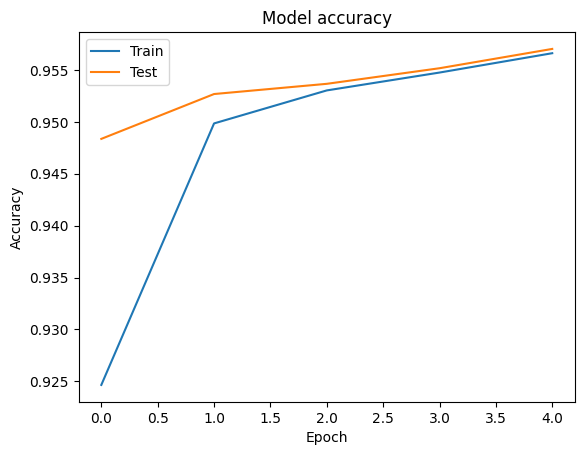

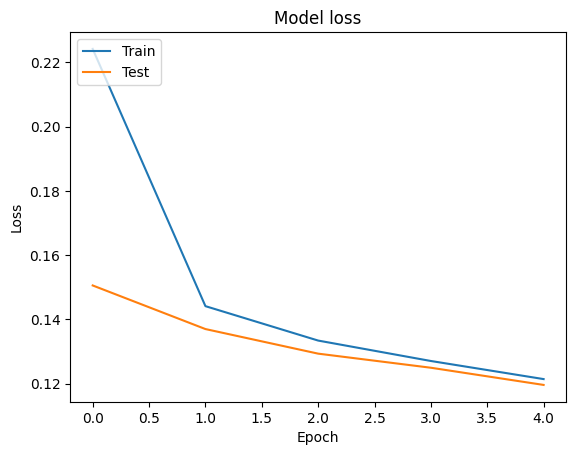

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 予測

検証データの予測値を取得して混同行列をチェックすることにより、5 つの各クラスのモデルの性能を確認することができます。`tf.keras.Model.predict` メソッドが各クラスの確率として N-D 配列を返すので、`np.argmax` を使用してそれらをクラスラベルに変換することができます。

In [21]:
y_pred = model.predict(validation_data)

  1/294 [..............................] - ETA: 40s

  5/294 [..............................] - ETA: 4s 

  9/294 [..............................] - ETA: 4s

 13/294 [>.............................] - ETA: 4s

 17/294 [>.............................] - ETA: 4s

 21/294 [=>............................] - ETA: 4s

 25/294 [=>............................] - ETA: 3s

 29/294 [=>............................] - ETA: 3s

 33/294 [==>...........................] - ETA: 3s

 37/294 [==>...........................] - ETA: 3s

 41/294 [===>..........................] - ETA: 3s

 45/294 [===>..........................] - ETA: 3s

 49/294 [====>.........................] - ETA: 3s

 53/294 [====>.........................] - ETA: 3s

 57/294 [====>.........................] - ETA: 3s

 61/294 [=====>........................] - ETA: 3s

 65/294 [=====>........................] - ETA: 3s

 69/294 [======>.......................] - ETA: 3s

 73/294 [======>.......................] - ETA: 3s

 77/294 [======>.......................] - ETA: 3s

 81/294 [=======>......................] - ETA: 3s

 84/294 [=======>......................] - ETA: 3s

 88/294 [=======>......................] - ETA: 3s

 92/294 [========>.....................] - ETA: 2s

 96/294 [========>.....................] - ETA: 2s

100/294 [=========>....................] - ETA: 2s

104/294 [=========>....................] - ETA: 2s

108/294 [==========>...................] - ETA: 2s

112/294 [==========>...................] - ETA: 2s

116/294 [==========>...................] - ETA: 2s

120/294 [===========>..................] - ETA: 2s

124/294 [===========>..................] - ETA: 2s

128/294 [============>.................] - ETA: 2s

132/294 [============>.................] - ETA: 2s

136/294 [============>.................] - ETA: 2s

140/294 [=============>................] - ETA: 2s

144/294 [=============>................] - ETA: 2s

148/294 [==============>...............] - ETA: 2s

152/294 [==============>...............] - ETA: 2s

156/294 [==============>...............] - ETA: 2s

160/294 [===============>..............] - ETA: 1s

164/294 [===============>..............] - ETA: 1s

168/294 [================>.............] - ETA: 1s

172/294 [================>.............] - ETA: 1s

176/294 [================>.............] - ETA: 1s

180/294 [=================>............] - ETA: 1s

184/294 [=================>............] - ETA: 1s

188/294 [==================>...........] - ETA: 1s

192/294 [==================>...........] - ETA: 1s

196/294 [===================>..........] - ETA: 1s

200/294 [===================>..........] - ETA: 1s

204/294 [===================>..........] - ETA: 1s

208/294 [====================>.........] - ETA: 1s

212/294 [====================>.........] - ETA: 1s

216/294 [=====================>........] - ETA: 1s

220/294 [=====================>........] - ETA: 1s

224/294 [=====================>........] - ETA: 1s

228/294 [======================>.......] - ETA: 0s

232/294 [======================>.......] - ETA: 0s

236/294 [=======================>......] - ETA: 0s

240/294 [=======================>......] - ETA: 0s

244/294 [=======================>......] - ETA: 0s

248/294 [========================>.....] - ETA: 0s

252/294 [========================>.....] - ETA: 0s

256/294 [=========================>....] - ETA: 0s

260/294 [=========================>....] - ETA: 0s

264/294 [=========================>....] - ETA: 0s

268/294 [==========================>...] - ETA: 0s

272/294 [==========================>...] - ETA: 0s

276/294 [===========================>..] - ETA: 0s

280/294 [===========================>..] - ETA: 0s

284/294 [===========================>..] - ETA: 0s

288/294 [============================>.] - ETA: 0s

292/294 [============================>.] - ETA: 0s

294/294 [==============================] - 4s 15ms/step


In [22]:
y_pred = np.argmax(y_pred, axis=1)

In [23]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class: ", sample.split("/")[0])
  print("Predicted Class: ", dir_names[y_pred[i]])
  f.close()
  


ঈদের সময় অধিকাংশ নির্মাতাই কয়েকটি করে নাটক নির্মাণ করলেও বছরের দুই ঈদে দুটি নাটক নির্মাণ করেন হানিফ
True Class:  entertainment
Predicted Class:  state

‘চৈত্র মাসে এভাবে পানিতে ধান নিতে দেখছি না। বৈশাখ মাসে বৃষ্টি অইতো। কৃষকেরা পাকনা ধান কিছু অইলেও তু
True Class:  state
Predicted Class:  state

পেশাদার ফুটবলার ছিলেন না, কোনো সংগঠকও নন। তারপরও ইতালির সিলভিও গাজ্জানিগার মৃত্যুতে ফুটবলের ইতিহাস 
True Class:  sports
Predicted Class:  state


## パフォーマンスを比較する

これで `labels`から検証データの正しいラベルを得ることができるようになったので、それを予測と比較して [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) を取得します。 

In [24]:
y_true = np.array(labels[train_size:])

In [25]:
print(classification_report(y_true, y_pred, target_names=dir_names))

               precision    recall  f1-score   support

      economy       0.82      0.78      0.79      3897
       sports       0.99      0.98      0.98     10204
entertainment       0.92      0.93      0.92      6256
        state       0.97      0.97      0.97     48512
international       0.93      0.93      0.93      6377

     accuracy                           0.96     75246
    macro avg       0.92      0.92      0.92     75246
 weighted avg       0.96      0.96      0.96     75246



また、発表されたオリジナルの[論文](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset)で結果として報告されている精度 0.96 とモデルの性能を比較することもできます。オリジナルの論文の著者は、句読点や数字を削除したり、最も頻繁に使われるストップワードの上位 25 個を削除したり、データセットに対して多くの前処理を行ったと説明しています。`classification_report` を見ると分かりますが、ここでは前処理を行わずに 5 エポック分のトレーニングを行っただけでも、0.96 の精度と正解率が得られています！

この例では、埋め込みモジュールから Keras レイヤーを作成する際に `trainable=False` を設定しました。つまり、トレーニング中に埋め込み重みを更新しないことを意味します。これを `True` 設定にしてこのデータセットでトレーニングを行ってみると、わずか 2 エポックで 97% の精度を達成します。 